In [6]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [7]:
%load_ext autoreload
%autoreload 2



args = arguments()
#boardio is for the the tensorboardx prensetaion and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'eval': <built-in function eval>, 'data': 'mnist', 'model': 'mlp', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 600, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 200, 'optimizer': 'Adam', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'seed': 0, 'alpha': 100, 'beta': 2, 'gamma': 5, 'max_seconds': 300, 'method_choosing_users': 'pause brute', 'data_truncation': 2000, 'choosing_users_verbose': False, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.04, 'delta_f': 0.003, 'device': device(type='cuda'), 'snr_verbose': False, 'max_iterations_sa_pause': 500, 'sa_pause_simulation': False, 'sa_pause_verbose': False, 'beta_max_reduction': 30, 'accel_ucb_coeff': 1, 'max_time_sa_pause': 600, 'pre_sa_pause_rounds': 1, 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, '

In [8]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC3Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Layer (type:depth-idx)                   Param #
FC3Layer                                 --
├─Linear: 1-1                            25,120
├─Linear: 1-2                            528
├─Linear: 1-3                            170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
global model's device: cuda:0


In [9]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  0%|          | 0/600 [00:00<?, ?it/s]

global epoch 1 has been done artifficialy in 0.72 secs, the total time by now is 0.72 
 with avg train loss 2.436, val loss 2.305, avg val acc 16.80%


  0%|          | 1/600 [00:02<25:28,  2.55s/it]

global epoch 2 has been done artifficialy in 0.84 secs, the total time by now is 1.56 
 with avg train loss 2.457, val loss 2.305, avg val acc 18.39%


  0%|          | 2/600 [00:05<26:08,  2.62s/it]

global epoch 3 has been done artifficialy in 0.88 secs, the total time by now is 2.44 
 with avg train loss 2.357, val loss 2.304, avg val acc 12.63%


  0%|          | 3/600 [00:07<25:24,  2.55s/it]

global epoch 4 has been done artifficialy in 0.87 secs, the total time by now is 3.31 
 with avg train loss 2.368, val loss 2.301, avg val acc 13.92%


  1%|          | 4/600 [00:10<24:54,  2.51s/it]

global epoch 5 has been done artifficialy in 0.83 secs, the total time by now is 4.13 
 with avg train loss 2.389, val loss 2.295, avg val acc 16.92%


  1%|          | 5/600 [00:12<24:47,  2.50s/it]

global epoch 6 has been done artifficialy in 0.89 secs, the total time by now is 5.02 
 with avg train loss 2.350, val loss 2.290, avg val acc 19.10%


  1%|          | 6/600 [00:15<24:56,  2.52s/it]

global epoch 7 has been done artifficialy in 0.15 secs, the total time by now is 5.17 
 with avg train loss 2.326, val loss 2.287, avg val acc 16.44%


  1%|          | 7/600 [00:17<24:57,  2.53s/it]

global epoch 8 has been done artifficialy in 0.19 secs, the total time by now is 5.36 
 with avg train loss 2.266, val loss 2.284, avg val acc 17.08%


  1%|▏         | 8/600 [00:20<24:51,  2.52s/it]

global epoch 9 has been done artifficialy in 0.25 secs, the total time by now is 5.61 
 with avg train loss 2.265, val loss 2.281, avg val acc 17.54%


  2%|▏         | 9/600 [00:22<24:54,  2.53s/it]

global epoch 10 has been done artifficialy in 0.78 secs, the total time by now is 6.39 
 with avg train loss 2.285, val loss 2.281, avg val acc 16.33%


  2%|▏         | 10/600 [00:25<24:48,  2.52s/it]

global epoch 11 has been done artifficialy in 0.87 secs, the total time by now is 7.26 
 with avg train loss 2.292, val loss 2.276, avg val acc 16.23%


  2%|▏         | 11/600 [00:27<24:49,  2.53s/it]

global epoch 12 has been done artifficialy in 0.96 secs, the total time by now is 8.22 
 with avg train loss 2.298, val loss 2.272, avg val acc 18.55%


  2%|▏         | 12/600 [00:30<25:06,  2.56s/it]

global epoch 13 has been done artifficialy in 0.12 secs, the total time by now is 8.34 
 with avg train loss 2.268, val loss 2.260, avg val acc 15.86%


  2%|▏         | 13/600 [00:33<25:17,  2.59s/it]

global epoch 14 has been done artifficialy in 0.19 secs, the total time by now is 8.53 
 with avg train loss 2.244, val loss 2.255, avg val acc 13.92%


  2%|▏         | 14/600 [00:35<25:21,  2.60s/it]

global epoch 15 has been done artifficialy in 0.30 secs, the total time by now is 8.83 
 with avg train loss 2.230, val loss 2.249, avg val acc 15.79%


  2%|▎         | 15/600 [00:38<25:13,  2.59s/it]

global epoch 16 has been done artifficialy in 0.84 secs, the total time by now is 9.67 
 with avg train loss 2.241, val loss 2.236, avg val acc 18.29%


  3%|▎         | 16/600 [00:40<25:06,  2.58s/it]

global epoch 17 has been done artifficialy in 0.83 secs, the total time by now is 10.50 
 with avg train loss 2.233, val loss 2.228, avg val acc 23.36%


  3%|▎         | 17/600 [00:43<24:54,  2.56s/it]

global epoch 18 has been done artifficialy in 0.90 secs, the total time by now is 11.41 
 with avg train loss 2.274, val loss 2.217, avg val acc 30.66%


  3%|▎         | 18/600 [00:45<25:02,  2.58s/it]

global epoch 19 has been done artifficialy in 0.16 secs, the total time by now is 11.57 
 with avg train loss 2.199, val loss 2.208, avg val acc 34.94%


  3%|▎         | 19/600 [00:48<25:06,  2.59s/it]

global epoch 20 has been done artifficialy in 0.23 secs, the total time by now is 11.80 
 with avg train loss 2.205, val loss 2.201, avg val acc 30.68%


  3%|▎         | 20/600 [00:51<25:06,  2.60s/it]

global epoch 21 has been done artifficialy in 0.26 secs, the total time by now is 12.05 
 with avg train loss 2.181, val loss 2.190, avg val acc 35.60%


  4%|▎         | 21/600 [00:53<24:57,  2.59s/it]

global epoch 22 has been done artifficialy in 0.87 secs, the total time by now is 12.92 
 with avg train loss 2.195, val loss 2.182, avg val acc 38.17%


  4%|▎         | 22/600 [00:56<25:01,  2.60s/it]

global epoch 23 has been done artifficialy in 0.87 secs, the total time by now is 13.79 
 with avg train loss 2.173, val loss 2.171, avg val acc 37.13%


  4%|▍         | 23/600 [00:59<25:02,  2.60s/it]

global epoch 24 has been done artifficialy in 0.88 secs, the total time by now is 14.67 
 with avg train loss 2.173, val loss 2.165, avg val acc 33.31%


  4%|▍         | 24/600 [01:01<25:06,  2.61s/it]

global epoch 25 has been done artifficialy in 0.11 secs, the total time by now is 14.78 
 with avg train loss 2.160, val loss 2.155, avg val acc 34.90%


  4%|▍         | 25/600 [01:04<25:05,  2.62s/it]

global epoch 26 has been done artifficialy in 0.16 secs, the total time by now is 14.94 
 with avg train loss 2.069, val loss 2.143, avg val acc 34.82%


  4%|▍         | 26/600 [01:06<25:16,  2.64s/it]

global epoch 27 has been done artifficialy in 0.27 secs, the total time by now is 15.21 
 with avg train loss 2.132, val loss 2.133, avg val acc 34.92%


  4%|▍         | 27/600 [01:09<25:17,  2.65s/it]

global epoch 28 has been done artifficialy in 0.16 secs, the total time by now is 15.37 
 with avg train loss 2.075, val loss 2.118, avg val acc 39.16%


  5%|▍         | 28/600 [01:12<25:12,  2.64s/it]

global epoch 29 has been done artifficialy in 0.80 secs, the total time by now is 16.17 
 with avg train loss 2.126, val loss 2.109, avg val acc 40.47%


  5%|▍         | 29/600 [01:14<25:07,  2.64s/it]

global epoch 30 has been done artifficialy in 0.89 secs, the total time by now is 17.06 
 with avg train loss 2.076, val loss 2.097, avg val acc 38.70%


  5%|▌         | 30/600 [01:17<25:02,  2.64s/it]

global epoch 31 has been done artifficialy in 0.92 secs, the total time by now is 17.98 
 with avg train loss 2.062, val loss 2.083, avg val acc 37.33%


  5%|▌         | 31/600 [01:20<25:09,  2.65s/it]

global epoch 32 has been done artifficialy in 0.17 secs, the total time by now is 18.15 
 with avg train loss 2.041, val loss 2.070, avg val acc 36.41%


  5%|▌         | 32/600 [01:22<25:08,  2.66s/it]

global epoch 33 has been done artifficialy in 0.19 secs, the total time by now is 18.34 
 with avg train loss 2.012, val loss 2.057, avg val acc 38.26%


  6%|▌         | 33/600 [01:25<25:20,  2.68s/it]

global epoch 34 has been done artifficialy in 0.20 secs, the total time by now is 18.54 
 with avg train loss 2.054, val loss 2.045, avg val acc 39.06%


  6%|▌         | 34/600 [01:28<25:29,  2.70s/it]

global epoch 35 has been done artifficialy in 0.73 secs, the total time by now is 19.27 
 with avg train loss 2.019, val loss 2.028, avg val acc 41.02%


  6%|▌         | 35/600 [01:31<25:30,  2.71s/it]

global epoch 36 has been done artifficialy in 0.88 secs, the total time by now is 20.15 
 with avg train loss 1.973, val loss 2.021, avg val acc 40.23%


  6%|▌         | 36/600 [01:33<25:27,  2.71s/it]

global epoch 37 has been done artifficialy in 0.95 secs, the total time by now is 21.10 
 with avg train loss 1.948, val loss 2.003, avg val acc 40.70%


  6%|▌         | 37/600 [01:36<25:31,  2.72s/it]

global epoch 38 has been done artifficialy in 0.19 secs, the total time by now is 21.29 
 with avg train loss 1.967, val loss 1.985, avg val acc 40.97%


  6%|▋         | 38/600 [01:39<25:35,  2.73s/it]

global epoch 39 has been done artifficialy in 0.24 secs, the total time by now is 21.53 
 with avg train loss 1.881, val loss 1.971, avg val acc 40.01%


  6%|▋         | 39/600 [01:42<25:28,  2.72s/it]

global epoch 40 has been done artifficialy in 0.27 secs, the total time by now is 21.80 
 with avg train loss 1.917, val loss 1.955, avg val acc 40.56%


  7%|▋         | 40/600 [01:44<25:24,  2.72s/it]

global epoch 41 has been done artifficialy in 0.17 secs, the total time by now is 21.97 
 with avg train loss 1.910, val loss 1.941, avg val acc 42.11%


  7%|▋         | 41/600 [01:47<25:21,  2.72s/it]

global epoch 42 has been done artifficialy in 0.83 secs, the total time by now is 22.80 
 with avg train loss 1.845, val loss 1.926, avg val acc 43.28%


  7%|▋         | 42/600 [01:50<25:21,  2.73s/it]

global epoch 43 has been done artifficialy in 0.90 secs, the total time by now is 23.70 
 with avg train loss 1.791, val loss 1.911, avg val acc 41.17%


  7%|▋         | 43/600 [01:52<25:20,  2.73s/it]

global epoch 44 has been done artifficialy in 0.95 secs, the total time by now is 24.65 
 with avg train loss 1.843, val loss 1.896, avg val acc 41.63%


  7%|▋         | 44/600 [01:55<25:48,  2.79s/it]

global epoch 45 has been done artifficialy in 0.15 secs, the total time by now is 24.81 
 with avg train loss 1.770, val loss 1.879, avg val acc 43.01%


  8%|▊         | 45/600 [01:58<26:00,  2.81s/it]

global epoch 46 has been done artifficialy in 0.22 secs, the total time by now is 25.03 
 with avg train loss 1.815, val loss 1.862, avg val acc 42.29%


  8%|▊         | 46/600 [02:01<25:56,  2.81s/it]

global epoch 47 has been done artifficialy in 0.21 secs, the total time by now is 25.24 
 with avg train loss 1.777, val loss 1.845, avg val acc 43.47%


  8%|▊         | 47/600 [02:04<25:59,  2.82s/it]

global epoch 48 has been done artifficialy in 0.75 secs, the total time by now is 25.99 
 with avg train loss 1.755, val loss 1.828, avg val acc 43.18%


  8%|▊         | 48/600 [02:07<25:54,  2.82s/it]

global epoch 49 has been done artifficialy in 0.87 secs, the total time by now is 26.87 
 with avg train loss 1.752, val loss 1.817, avg val acc 43.27%


  8%|▊         | 49/600 [02:10<25:53,  2.82s/it]

global epoch 50 has been done artifficialy in 0.90 secs, the total time by now is 27.77 
 with avg train loss 1.709, val loss 1.797, avg val acc 42.11%


  8%|▊         | 50/600 [02:12<26:00,  2.84s/it]

global epoch 51 has been done artifficialy in 0.18 secs, the total time by now is 27.95 
 with avg train loss 1.686, val loss 1.782, avg val acc 42.88%


  8%|▊         | 51/600 [02:15<26:12,  2.86s/it]

global epoch 52 has been done artifficialy in 0.18 secs, the total time by now is 28.13 
 with avg train loss 1.681, val loss 1.764, avg val acc 43.27%


  9%|▊         | 52/600 [02:18<26:18,  2.88s/it]

global epoch 53 has been done artifficialy in 0.18 secs, the total time by now is 28.31 
 with avg train loss 1.663, val loss 1.745, avg val acc 43.79%


  9%|▉         | 53/600 [02:21<26:29,  2.91s/it]

global epoch 54 has been done artifficialy in 0.81 secs, the total time by now is 29.12 
 with avg train loss 1.685, val loss 1.727, avg val acc 44.53%


  9%|▉         | 54/600 [02:24<26:42,  2.94s/it]

global epoch 55 has been done artifficialy in 0.87 secs, the total time by now is 29.99 
 with avg train loss 1.596, val loss 1.711, avg val acc 44.18%


  9%|▉         | 55/600 [02:27<26:40,  2.94s/it]

global epoch 56 has been done artifficialy in 0.94 secs, the total time by now is 30.93 
 with avg train loss 1.594, val loss 1.693, avg val acc 43.86%


  9%|▉         | 56/600 [02:30<26:48,  2.96s/it]

global epoch 57 has been done artifficialy in 0.16 secs, the total time by now is 31.10 
 with avg train loss 1.605, val loss 1.676, avg val acc 44.90%


 10%|▉         | 57/600 [02:33<26:45,  2.96s/it]

global epoch 58 has been done artifficialy in 0.27 secs, the total time by now is 31.37 
 with avg train loss 1.572, val loss 1.660, avg val acc 45.66%


 10%|▉         | 58/600 [02:36<26:42,  2.96s/it]

global epoch 59 has been done artifficialy in 0.15 secs, the total time by now is 31.52 
 with avg train loss 1.611, val loss 1.647, avg val acc 46.57%


 10%|▉         | 59/600 [02:39<26:41,  2.96s/it]

global epoch 60 has been done artifficialy in 0.23 secs, the total time by now is 31.75 
 with avg train loss 1.567, val loss 1.628, avg val acc 45.94%


 10%|█         | 60/600 [02:42<26:34,  2.95s/it]

global epoch 61 has been done artifficialy in 0.83 secs, the total time by now is 32.58 
 with avg train loss 1.575, val loss 1.612, avg val acc 46.44%


 10%|█         | 61/600 [02:45<26:25,  2.94s/it]

global epoch 62 has been done artifficialy in 0.88 secs, the total time by now is 33.47 
 with avg train loss 1.525, val loss 1.597, avg val acc 46.72%


 10%|█         | 62/600 [02:48<26:21,  2.94s/it]

global epoch 63 has been done artifficialy in 0.96 secs, the total time by now is 34.43 
 with avg train loss 1.453, val loss 1.584, avg val acc 46.02%


 10%|█         | 63/600 [02:51<26:18,  2.94s/it]

global epoch 64 has been done artifficialy in 0.17 secs, the total time by now is 34.59 
 with avg train loss 1.513, val loss 1.568, avg val acc 45.80%


 11%|█         | 64/600 [02:54<26:16,  2.94s/it]

global epoch 65 has been done artifficialy in 0.17 secs, the total time by now is 34.76 
 with avg train loss 1.517, val loss 1.552, avg val acc 46.11%


 11%|█         | 65/600 [02:57<26:18,  2.95s/it]

global epoch 66 has been done artifficialy in 0.11 secs, the total time by now is 34.88 
 with avg train loss 1.463, val loss 1.536, avg val acc 46.89%


 11%|█         | 66/600 [03:00<26:19,  2.96s/it]

global epoch 67 has been done artifficialy in 0.80 secs, the total time by now is 35.68 
 with avg train loss 1.461, val loss 1.520, avg val acc 47.53%


 11%|█         | 67/600 [03:03<26:20,  2.97s/it]

global epoch 68 has been done artifficialy in 0.87 secs, the total time by now is 36.55 
 with avg train loss 1.427, val loss 1.504, avg val acc 47.56%


 11%|█▏        | 68/600 [03:06<26:22,  2.97s/it]

global epoch 69 has been done artifficialy in 0.96 secs, the total time by now is 37.51 
 with avg train loss 1.432, val loss 1.489, avg val acc 47.55%


 12%|█▏        | 69/600 [03:09<26:27,  2.99s/it]

global epoch 70 has been done artifficialy in 0.20 secs, the total time by now is 37.70 
 with avg train loss 1.502, val loss 1.473, avg val acc 48.17%


 12%|█▏        | 70/600 [03:12<26:26,  2.99s/it]

global epoch 71 has been done artifficialy in 0.28 secs, the total time by now is 37.98 
 with avg train loss 1.411, val loss 1.456, avg val acc 48.97%


 12%|█▏        | 71/600 [03:15<26:24,  3.00s/it]

global epoch 72 has been done artifficialy in 0.12 secs, the total time by now is 38.10 
 with avg train loss 1.439, val loss 1.442, avg val acc 49.25%


 12%|█▏        | 72/600 [03:18<26:24,  3.00s/it]

global epoch 73 has been done artifficialy in 0.76 secs, the total time by now is 38.86 
 with avg train loss 1.391, val loss 1.428, avg val acc 50.48%


 12%|█▏        | 73/600 [03:21<26:24,  3.01s/it]

global epoch 74 has been done artifficialy in 0.87 secs, the total time by now is 39.73 
 with avg train loss 1.440, val loss 1.415, avg val acc 50.59%


 12%|█▏        | 74/600 [03:24<26:27,  3.02s/it]

global epoch 75 has been done artifficialy in 0.95 secs, the total time by now is 40.67 
 with avg train loss 1.331, val loss 1.398, avg val acc 50.75%


 12%|█▎        | 75/600 [03:27<26:31,  3.03s/it]

global epoch 76 has been done artifficialy in 0.21 secs, the total time by now is 40.88 
 with avg train loss 1.306, val loss 1.383, avg val acc 52.22%


 13%|█▎        | 76/600 [03:30<26:38,  3.05s/it]

global epoch 77 has been done artifficialy in 0.10 secs, the total time by now is 40.98 
 with avg train loss 1.379, val loss 1.369, avg val acc 53.49%


 13%|█▎        | 77/600 [03:33<26:48,  3.08s/it]

global epoch 78 has been done artifficialy in 0.20 secs, the total time by now is 41.19 
 with avg train loss 1.349, val loss 1.356, avg val acc 54.02%


 13%|█▎        | 78/600 [03:36<26:48,  3.08s/it]

global epoch 79 has been done artifficialy in 0.13 secs, the total time by now is 41.32 
 with avg train loss 1.280, val loss 1.343, avg val acc 54.91%


 13%|█▎        | 79/600 [03:39<26:44,  3.08s/it]

global epoch 80 has been done artifficialy in 0.84 secs, the total time by now is 42.16 
 with avg train loss 1.351, val loss 1.327, avg val acc 55.44%


 13%|█▎        | 80/600 [03:42<26:43,  3.08s/it]

global epoch 81 has been done artifficialy in 0.92 secs, the total time by now is 43.08 
 with avg train loss 1.315, val loss 1.314, avg val acc 55.91%


 14%|█▎        | 81/600 [03:45<26:44,  3.09s/it]

global epoch 82 has been done artifficialy in 1.00 secs, the total time by now is 44.08 
 with avg train loss 1.297, val loss 1.301, avg val acc 56.19%


 14%|█▎        | 82/600 [03:49<26:46,  3.10s/it]

global epoch 83 has been done artifficialy in 0.17 secs, the total time by now is 44.26 
 with avg train loss 1.316, val loss 1.290, avg val acc 57.24%


 14%|█▍        | 83/600 [03:52<26:45,  3.11s/it]

global epoch 84 has been done artifficialy in 0.24 secs, the total time by now is 44.50 
 with avg train loss 1.225, val loss 1.275, avg val acc 58.16%


 14%|█▍        | 84/600 [03:55<26:44,  3.11s/it]

global epoch 85 has been done artifficialy in 0.16 secs, the total time by now is 44.66 
 with avg train loss 1.228, val loss 1.262, avg val acc 58.48%


 14%|█▍        | 85/600 [03:58<26:46,  3.12s/it]

global epoch 86 has been done artifficialy in 0.18 secs, the total time by now is 44.84 
 with avg train loss 1.281, val loss 1.252, avg val acc 59.63%


 14%|█▍        | 86/600 [04:01<26:53,  3.14s/it]

global epoch 87 has been done artifficialy in 0.79 secs, the total time by now is 45.63 
 with avg train loss 1.206, val loss 1.241, avg val acc 59.99%


 14%|█▍        | 87/600 [04:04<26:51,  3.14s/it]

global epoch 88 has been done artifficialy in 0.88 secs, the total time by now is 46.51 
 with avg train loss 1.186, val loss 1.228, avg val acc 60.02%


 15%|█▍        | 88/600 [04:07<26:49,  3.14s/it]

global epoch 89 has been done artifficialy in 0.93 secs, the total time by now is 47.44 
 with avg train loss 1.162, val loss 1.218, avg val acc 60.25%


 15%|█▍        | 89/600 [04:11<26:52,  3.15s/it]

global epoch 90 has been done artifficialy in 0.20 secs, the total time by now is 47.64 
 with avg train loss 1.175, val loss 1.203, avg val acc 61.27%


 15%|█▌        | 90/600 [04:14<26:51,  3.16s/it]

global epoch 91 has been done artifficialy in 0.19 secs, the total time by now is 47.83 
 with avg train loss 1.126, val loss 1.192, avg val acc 61.57%


 15%|█▌        | 91/600 [04:17<26:52,  3.17s/it]

global epoch 92 has been done artifficialy in 0.17 secs, the total time by now is 47.99 
 with avg train loss 1.186, val loss 1.183, avg val acc 62.50%


 15%|█▌        | 92/600 [04:20<26:53,  3.18s/it]

global epoch 93 has been done artifficialy in 0.81 secs, the total time by now is 48.81 
 with avg train loss 1.081, val loss 1.168, avg val acc 63.09%


 16%|█▌        | 93/600 [04:23<26:54,  3.18s/it]

global epoch 94 has been done artifficialy in 0.86 secs, the total time by now is 49.67 
 with avg train loss 1.156, val loss 1.158, avg val acc 63.06%


 16%|█▌        | 94/600 [04:27<26:55,  3.19s/it]

global epoch 95 has been done artifficialy in 0.94 secs, the total time by now is 50.61 
 with avg train loss 1.135, val loss 1.146, avg val acc 63.59%


 16%|█▌        | 95/600 [04:30<27:02,  3.21s/it]

global epoch 96 has been done artifficialy in 0.26 secs, the total time by now is 50.87 
 with avg train loss 1.115, val loss 1.131, avg val acc 64.45%


 16%|█▌        | 96/600 [04:33<27:00,  3.22s/it]

global epoch 97 has been done artifficialy in 0.19 secs, the total time by now is 51.06 
 with avg train loss 1.092, val loss 1.122, avg val acc 64.25%


 16%|█▌        | 97/600 [04:36<27:02,  3.23s/it]

global epoch 98 has been done artifficialy in 0.22 secs, the total time by now is 51.28 
 with avg train loss 1.071, val loss 1.109, avg val acc 65.17%


 16%|█▋        | 98/600 [04:40<27:01,  3.23s/it]

global epoch 99 has been done artifficialy in 0.14 secs, the total time by now is 51.42 
 with avg train loss 1.118, val loss 1.101, avg val acc 65.65%


 16%|█▋        | 99/600 [04:43<27:03,  3.24s/it]

global epoch 100 has been done artifficialy in 0.78 secs, the total time by now is 52.20 
 with avg train loss 1.030, val loss 1.094, avg val acc 65.69%


 17%|█▋        | 100/600 [04:46<27:05,  3.25s/it]

global epoch 101 has been done artifficialy in 0.86 secs, the total time by now is 53.06 
 with avg train loss 1.083, val loss 1.081, avg val acc 66.12%


 17%|█▋        | 101/600 [04:49<27:06,  3.26s/it]

global epoch 102 has been done artifficialy in 0.94 secs, the total time by now is 54.00 
 with avg train loss 1.081, val loss 1.076, avg val acc 66.10%


 17%|█▋        | 102/600 [04:53<27:08,  3.27s/it]

global epoch 103 has been done artifficialy in 0.16 secs, the total time by now is 54.16 
 with avg train loss 1.008, val loss 1.060, avg val acc 66.58%


 17%|█▋        | 103/600 [04:56<27:11,  3.28s/it]

global epoch 104 has been done artifficialy in 0.22 secs, the total time by now is 54.37 
 with avg train loss 1.087, val loss 1.053, avg val acc 66.91%


 17%|█▋        | 104/600 [04:59<27:18,  3.30s/it]

global epoch 105 has been done artifficialy in 0.19 secs, the total time by now is 54.56 
 with avg train loss 1.040, val loss 1.044, avg val acc 67.25%


 18%|█▊        | 105/600 [05:03<27:16,  3.31s/it]

global epoch 106 has been done artifficialy in 0.80 secs, the total time by now is 55.36 
 with avg train loss 1.046, val loss 1.033, avg val acc 68.09%


 18%|█▊        | 106/600 [05:06<27:15,  3.31s/it]

global epoch 107 has been done artifficialy in 0.93 secs, the total time by now is 56.29 
 with avg train loss 1.027, val loss 1.027, avg val acc 68.10%


 18%|█▊        | 107/600 [05:09<27:17,  3.32s/it]

global epoch 108 has been done artifficialy in 0.96 secs, the total time by now is 57.25 
 with avg train loss 1.193, val loss 1.021, avg val acc 68.55%


 18%|█▊        | 108/600 [05:13<27:16,  3.33s/it]

global epoch 109 has been done artifficialy in 0.10 secs, the total time by now is 57.35 
 with avg train loss 0.959, val loss 1.010, avg val acc 68.91%


 18%|█▊        | 109/600 [05:16<27:15,  3.33s/it]

global epoch 110 has been done artifficialy in 0.20 secs, the total time by now is 57.56 
 with avg train loss 1.057, val loss 1.004, avg val acc 68.77%


 18%|█▊        | 110/600 [05:19<27:17,  3.34s/it]

global epoch 111 has been done artifficialy in 0.29 secs, the total time by now is 57.85 
 with avg train loss 0.942, val loss 0.991, avg val acc 69.10%


 18%|█▊        | 111/600 [05:23<27:17,  3.35s/it]

global epoch 112 has been done artifficialy in 0.82 secs, the total time by now is 58.66 
 with avg train loss 1.084, val loss 0.985, avg val acc 69.58%


 19%|█▊        | 112/600 [05:26<27:19,  3.36s/it]

global epoch 113 has been done artifficialy in 0.83 secs, the total time by now is 59.49 
 with avg train loss 0.952, val loss 0.977, avg val acc 69.35%


 19%|█▉        | 113/600 [05:29<27:22,  3.37s/it]

global epoch 114 has been done artifficialy in 0.95 secs, the total time by now is 60.45 
 with avg train loss 1.093, val loss 0.971, avg val acc 69.71%


 19%|█▉        | 114/600 [05:33<27:23,  3.38s/it]

global epoch 115 has been done artifficialy in 0.13 secs, the total time by now is 60.57 
 with avg train loss 0.949, val loss 0.962, avg val acc 69.97%


 19%|█▉        | 115/600 [05:36<27:20,  3.38s/it]

global epoch 116 has been done artifficialy in 0.17 secs, the total time by now is 60.74 
 with avg train loss 1.009, val loss 0.958, avg val acc 70.28%


 19%|█▉        | 116/600 [05:40<27:25,  3.40s/it]

global epoch 117 has been done artifficialy in 0.22 secs, the total time by now is 60.96 
 with avg train loss 0.955, val loss 0.948, avg val acc 70.25%


 20%|█▉        | 117/600 [05:43<27:25,  3.41s/it]

global epoch 118 has been done artifficialy in 0.80 secs, the total time by now is 61.76 
 with avg train loss 1.154, val loss 0.939, avg val acc 71.11%


 20%|█▉        | 118/600 [05:47<27:27,  3.42s/it]

global epoch 119 has been done artifficialy in 0.12 secs, the total time by now is 61.88 
 with avg train loss 0.844, val loss 0.932, avg val acc 71.48%


 20%|█▉        | 119/600 [05:50<27:26,  3.42s/it]

global epoch 120 has been done artifficialy in 0.83 secs, the total time by now is 62.71 
 with avg train loss 0.919, val loss 0.926, avg val acc 70.64%


 20%|██        | 120/600 [05:53<27:29,  3.44s/it]

global epoch 121 has been done artifficialy in 1.01 secs, the total time by now is 63.72 
 with avg train loss 1.023, val loss 0.928, avg val acc 70.29%


 20%|██        | 121/600 [05:57<27:29,  3.44s/it]

global epoch 122 has been done artifficialy in 0.21 secs, the total time by now is 63.93 
 with avg train loss 0.981, val loss 0.918, avg val acc 71.26%


 20%|██        | 122/600 [06:00<27:36,  3.47s/it]

global epoch 123 has been done artifficialy in 0.20 secs, the total time by now is 64.12 
 with avg train loss 0.860, val loss 0.911, avg val acc 71.06%


 20%|██        | 123/600 [06:04<27:36,  3.47s/it]

global epoch 124 has been done artifficialy in 0.14 secs, the total time by now is 64.26 
 with avg train loss 0.795, val loss 0.900, avg val acc 71.72%


 21%|██        | 124/600 [06:07<27:31,  3.47s/it]

global epoch 125 has been done artifficialy in 0.86 secs, the total time by now is 65.13 
 with avg train loss 1.042, val loss 0.897, avg val acc 71.93%


 21%|██        | 125/600 [06:11<27:30,  3.47s/it]

global epoch 126 has been done artifficialy in 0.93 secs, the total time by now is 66.05 
 with avg train loss 0.896, val loss 0.891, avg val acc 71.43%


 21%|██        | 126/600 [06:14<27:27,  3.48s/it]

global epoch 127 has been done artifficialy in 0.92 secs, the total time by now is 66.98 
 with avg train loss 0.862, val loss 0.890, avg val acc 71.50%


 21%|██        | 127/600 [06:18<27:29,  3.49s/it]

global epoch 128 has been done artifficialy in 0.17 secs, the total time by now is 67.15 
 with avg train loss 0.902, val loss 0.881, avg val acc 72.18%


 21%|██▏       | 128/600 [06:21<27:28,  3.49s/it]

global epoch 129 has been done artifficialy in 0.25 secs, the total time by now is 67.40 
 with avg train loss 0.947, val loss 0.873, avg val acc 72.48%


 22%|██▏       | 129/600 [06:25<27:28,  3.50s/it]

global epoch 130 has been done artifficialy in 0.17 secs, the total time by now is 67.57 
 with avg train loss 0.842, val loss 0.866, avg val acc 73.06%


 22%|██▏       | 130/600 [06:28<27:31,  3.51s/it]

global epoch 131 has been done artifficialy in 0.81 secs, the total time by now is 68.38 
 with avg train loss 0.945, val loss 0.863, avg val acc 72.67%


 22%|██▏       | 131/600 [06:32<27:36,  3.53s/it]

global epoch 132 has been done artifficialy in 0.87 secs, the total time by now is 69.25 
 with avg train loss 0.791, val loss 0.861, avg val acc 72.03%


 22%|██▏       | 132/600 [06:36<27:37,  3.54s/it]

global epoch 133 has been done artifficialy in 0.95 secs, the total time by now is 70.20 
 with avg train loss 0.852, val loss 0.856, avg val acc 72.89%


 22%|██▏       | 133/600 [06:39<27:36,  3.55s/it]

global epoch 134 has been done artifficialy in 0.28 secs, the total time by now is 70.48 
 with avg train loss 0.880, val loss 0.852, avg val acc 73.17%


 22%|██▏       | 134/600 [06:43<27:39,  3.56s/it]

global epoch 135 has been done artifficialy in 0.20 secs, the total time by now is 70.67 
 with avg train loss 0.899, val loss 0.844, avg val acc 73.67%


 22%|██▎       | 135/600 [06:46<27:37,  3.56s/it]

global epoch 136 has been done artifficialy in 0.13 secs, the total time by now is 70.80 
 with avg train loss 0.812, val loss 0.838, avg val acc 73.60%


 23%|██▎       | 136/600 [06:50<27:35,  3.57s/it]

global epoch 137 has been done artifficialy in 0.78 secs, the total time by now is 71.59 
 with avg train loss 0.867, val loss 0.833, avg val acc 74.55%


 23%|██▎       | 137/600 [06:53<27:38,  3.58s/it]

global epoch 138 has been done artifficialy in 0.21 secs, the total time by now is 71.80 
 with avg train loss 0.912, val loss 0.827, avg val acc 74.02%


 23%|██▎       | 138/600 [06:57<27:43,  3.60s/it]

global epoch 139 has been done artifficialy in 0.84 secs, the total time by now is 72.64 
 with avg train loss 0.692, val loss 0.823, avg val acc 74.20%


 23%|██▎       | 139/600 [07:01<27:44,  3.61s/it]

global epoch 140 has been done artifficialy in 0.91 secs, the total time by now is 73.56 
 with avg train loss 0.832, val loss 0.824, avg val acc 74.59%


 23%|██▎       | 140/600 [07:04<27:42,  3.61s/it]

global epoch 141 has been done artifficialy in 0.19 secs, the total time by now is 73.75 
 with avg train loss 0.823, val loss 0.817, avg val acc 74.42%


 24%|██▎       | 141/600 [07:08<27:38,  3.61s/it]

global epoch 142 has been done artifficialy in 0.21 secs, the total time by now is 73.95 
 with avg train loss 0.838, val loss 0.813, avg val acc 74.78%


 24%|██▎       | 142/600 [07:12<27:37,  3.62s/it]

global epoch 143 has been done artifficialy in 0.21 secs, the total time by now is 74.16 
 with avg train loss 0.917, val loss 0.813, avg val acc 75.22%


 24%|██▍       | 143/600 [07:15<27:39,  3.63s/it]

global epoch 144 has been done artifficialy in 0.78 secs, the total time by now is 74.95 
 with avg train loss 0.833, val loss 0.810, avg val acc 75.29%


 24%|██▍       | 144/600 [07:19<27:40,  3.64s/it]

global epoch 145 has been done artifficialy in 0.93 secs, the total time by now is 75.88 
 with avg train loss 0.746, val loss 0.800, avg val acc 75.28%


 24%|██▍       | 145/600 [07:23<27:44,  3.66s/it]

global epoch 146 has been done artifficialy in 0.16 secs, the total time by now is 76.03 
 with avg train loss 0.752, val loss 0.797, avg val acc 75.36%


 24%|██▍       | 146/600 [07:26<27:44,  3.67s/it]

global epoch 147 has been done artifficialy in 0.93 secs, the total time by now is 76.96 
 with avg train loss 0.815, val loss 0.795, avg val acc 75.35%


 24%|██▍       | 147/600 [07:30<27:47,  3.68s/it]

global epoch 148 has been done artifficialy in 0.20 secs, the total time by now is 77.17 
 with avg train loss 0.815, val loss 0.788, avg val acc 75.30%


 25%|██▍       | 148/600 [07:34<27:47,  3.69s/it]

global epoch 149 has been done artifficialy in 0.23 secs, the total time by now is 77.40 
 with avg train loss 0.717, val loss 0.787, avg val acc 75.48%


 25%|██▍       | 149/600 [07:38<27:50,  3.70s/it]

global epoch 150 has been done artifficialy in 0.13 secs, the total time by now is 77.53 
 with avg train loss 0.758, val loss 0.780, avg val acc 75.31%


 25%|██▌       | 150/600 [07:41<27:48,  3.71s/it]

global epoch 151 has been done artifficialy in 0.81 secs, the total time by now is 78.34 
 with avg train loss 0.920, val loss 0.776, avg val acc 75.91%


 25%|██▌       | 151/600 [07:45<27:44,  3.71s/it]

global epoch 152 has been done artifficialy in 0.88 secs, the total time by now is 79.22 
 with avg train loss 0.772, val loss 0.772, avg val acc 75.97%


 25%|██▌       | 152/600 [07:49<27:45,  3.72s/it]

global epoch 153 has been done artifficialy in 0.90 secs, the total time by now is 80.12 
 with avg train loss 0.764, val loss 0.770, avg val acc 75.86%


 26%|██▌       | 153/600 [07:52<27:45,  3.73s/it]

global epoch 154 has been done artifficialy in 0.20 secs, the total time by now is 80.32 
 with avg train loss 0.783, val loss 0.763, avg val acc 76.00%


 26%|██▌       | 154/600 [07:56<27:44,  3.73s/it]

global epoch 155 has been done artifficialy in 0.27 secs, the total time by now is 80.59 
 with avg train loss 0.688, val loss 0.758, avg val acc 75.94%


 26%|██▌       | 155/600 [08:00<27:47,  3.75s/it]

global epoch 156 has been done artifficialy in 0.07 secs, the total time by now is 80.66 
 with avg train loss 0.703, val loss 0.754, avg val acc 76.13%


 26%|██▌       | 156/600 [08:04<27:47,  3.76s/it]

global epoch 157 has been done artifficialy in 0.84 secs, the total time by now is 81.50 
 with avg train loss 0.882, val loss 0.754, avg val acc 76.84%


 26%|██▌       | 157/600 [08:08<27:49,  3.77s/it]

global epoch 158 has been done artifficialy in 0.86 secs, the total time by now is 82.36 
 with avg train loss 0.722, val loss 0.748, avg val acc 76.71%


 26%|██▋       | 158/600 [08:11<27:46,  3.77s/it]

global epoch 159 has been done artifficialy in 0.95 secs, the total time by now is 83.31 
 with avg train loss 0.775, val loss 0.745, avg val acc 77.16%


 26%|██▋       | 159/600 [08:15<27:47,  3.78s/it]

global epoch 160 has been done artifficialy in 0.21 secs, the total time by now is 83.52 
 with avg train loss 0.739, val loss 0.741, avg val acc 77.07%


 27%|██▋       | 160/600 [08:19<27:48,  3.79s/it]

global epoch 161 has been done artifficialy in 0.16 secs, the total time by now is 83.67 
 with avg train loss 0.698, val loss 0.740, avg val acc 76.80%


 27%|██▋       | 161/600 [08:23<27:49,  3.80s/it]

global epoch 162 has been done artifficialy in 0.29 secs, the total time by now is 83.97 
 with avg train loss 0.728, val loss 0.741, avg val acc 76.57%


 27%|██▋       | 162/600 [08:27<27:45,  3.80s/it]

global epoch 163 has been done artifficialy in 0.17 secs, the total time by now is 84.14 
 with avg train loss 0.792, val loss 0.733, avg val acc 77.06%


 27%|██▋       | 163/600 [08:30<27:49,  3.82s/it]

global epoch 164 has been done artifficialy in 0.81 secs, the total time by now is 84.95 
 with avg train loss 0.767, val loss 0.735, avg val acc 77.55%


 27%|██▋       | 164/600 [08:34<27:47,  3.82s/it]

global epoch 165 has been done artifficialy in 0.90 secs, the total time by now is 85.84 
 with avg train loss 0.584, val loss 0.725, avg val acc 77.94%


 28%|██▊       | 165/600 [08:38<27:46,  3.83s/it]

global epoch 166 has been done artifficialy in 0.96 secs, the total time by now is 86.80 
 with avg train loss 0.704, val loss 0.723, avg val acc 78.04%


 28%|██▊       | 166/600 [08:42<27:46,  3.84s/it]

global epoch 167 has been done artifficialy in 0.15 secs, the total time by now is 86.95 
 with avg train loss 0.594, val loss 0.720, avg val acc 77.60%


 28%|██▊       | 167/600 [08:46<27:46,  3.85s/it]

global epoch 168 has been done artifficialy in 0.20 secs, the total time by now is 87.15 
 with avg train loss 0.739, val loss 0.722, avg val acc 77.12%


 28%|██▊       | 168/600 [08:50<27:43,  3.85s/it]

global epoch 169 has been done artifficialy in 0.15 secs, the total time by now is 87.30 
 with avg train loss 0.679, val loss 0.713, avg val acc 77.84%


 28%|██▊       | 169/600 [08:54<27:44,  3.86s/it]

global epoch 170 has been done artifficialy in 0.17 secs, the total time by now is 87.47 
 with avg train loss 0.572, val loss 0.712, avg val acc 77.57%


 28%|██▊       | 170/600 [08:57<27:49,  3.88s/it]

global epoch 171 has been done artifficialy in 0.78 secs, the total time by now is 88.25 
 with avg train loss 0.721, val loss 0.706, avg val acc 77.80%


 28%|██▊       | 171/600 [09:01<27:50,  3.89s/it]

global epoch 172 has been done artifficialy in 0.82 secs, the total time by now is 89.07 
 with avg train loss 0.687, val loss 0.705, avg val acc 78.38%


 29%|██▊       | 172/600 [09:05<27:47,  3.90s/it]

global epoch 173 has been done artifficialy in 0.98 secs, the total time by now is 90.05 
 with avg train loss 0.703, val loss 0.702, avg val acc 78.28%


 29%|██▉       | 173/600 [09:09<27:47,  3.90s/it]

global epoch 174 has been done artifficialy in 0.27 secs, the total time by now is 90.33 
 with avg train loss 0.667, val loss 0.699, avg val acc 78.08%


 29%|██▉       | 174/600 [09:13<27:45,  3.91s/it]

global epoch 175 has been done artifficialy in 0.20 secs, the total time by now is 90.52 
 with avg train loss 0.688, val loss 0.696, avg val acc 78.42%


 29%|██▉       | 175/600 [09:17<27:45,  3.92s/it]

global epoch 176 has been done artifficialy in 0.18 secs, the total time by now is 90.70 
 with avg train loss 0.538, val loss 0.692, avg val acc 78.42%


 29%|██▉       | 176/600 [09:21<27:42,  3.92s/it]

global epoch 177 has been done artifficialy in 0.76 secs, the total time by now is 91.46 
 with avg train loss 0.682, val loss 0.688, avg val acc 78.76%


 30%|██▉       | 177/600 [09:25<27:42,  3.93s/it]

global epoch 178 has been done artifficialy in 0.82 secs, the total time by now is 92.28 
 with avg train loss 0.686, val loss 0.687, avg val acc 79.02%


 30%|██▉       | 178/600 [09:29<27:42,  3.94s/it]

global epoch 179 has been done artifficialy in 0.94 secs, the total time by now is 93.23 
 with avg train loss 0.685, val loss 0.687, avg val acc 78.98%


 30%|██▉       | 179/600 [09:33<27:43,  3.95s/it]

global epoch 180 has been done artifficialy in 0.21 secs, the total time by now is 93.44 
 with avg train loss 0.691, val loss 0.684, avg val acc 79.20%


 30%|███       | 180/600 [09:37<27:43,  3.96s/it]

global epoch 181 has been done artifficialy in 0.23 secs, the total time by now is 93.67 
 with avg train loss 0.693, val loss 0.679, avg val acc 78.98%


 30%|███       | 181/600 [09:41<27:43,  3.97s/it]

global epoch 182 has been done artifficialy in 0.19 secs, the total time by now is 93.85 
 with avg train loss 0.599, val loss 0.679, avg val acc 78.72%


 30%|███       | 182/600 [09:45<27:43,  3.98s/it]

global epoch 183 has been done artifficialy in 0.83 secs, the total time by now is 94.69 
 with avg train loss 0.690, val loss 0.674, avg val acc 79.23%


 30%|███       | 183/600 [09:49<27:41,  3.99s/it]

global epoch 184 has been done artifficialy in 0.85 secs, the total time by now is 95.53 
 with avg train loss 0.641, val loss 0.674, avg val acc 79.18%


 31%|███       | 184/600 [09:53<27:42,  4.00s/it]

global epoch 185 has been done artifficialy in 0.95 secs, the total time by now is 96.48 
 with avg train loss 0.756, val loss 0.672, avg val acc 79.03%


 31%|███       | 185/600 [09:57<27:41,  4.00s/it]

global epoch 186 has been done artifficialy in 0.27 secs, the total time by now is 96.76 
 with avg train loss 0.651, val loss 0.669, avg val acc 79.36%


 31%|███       | 186/600 [10:01<27:44,  4.02s/it]

global epoch 187 has been done artifficialy in 0.15 secs, the total time by now is 96.90 
 with avg train loss 0.596, val loss 0.662, avg val acc 79.78%


 31%|███       | 187/600 [10:05<27:45,  4.03s/it]

global epoch 188 has been done artifficialy in 0.22 secs, the total time by now is 97.12 
 with avg train loss 0.669, val loss 0.661, avg val acc 79.69%


 31%|███▏      | 188/600 [10:09<27:41,  4.03s/it]

global epoch 189 has been done artifficialy in 0.88 secs, the total time by now is 98.00 
 with avg train loss 0.610, val loss 0.664, avg val acc 79.82%


 32%|███▏      | 189/600 [10:13<27:41,  4.04s/it]

global epoch 190 has been done artifficialy in 0.99 secs, the total time by now is 98.99 
 with avg train loss 0.643, val loss 0.662, avg val acc 79.82%


 32%|███▏      | 190/600 [10:17<27:42,  4.05s/it]

global epoch 191 has been done artifficialy in 0.96 secs, the total time by now is 99.95 
 with avg train loss 0.680, val loss 0.660, avg val acc 79.69%


 32%|███▏      | 191/600 [10:21<27:45,  4.07s/it]

global epoch 192 has been done artifficialy in 0.09 secs, the total time by now is 100.04 
 with avg train loss 0.510, val loss 0.653, avg val acc 79.90%


 32%|███▏      | 192/600 [10:25<27:44,  4.08s/it]

global epoch 193 has been done artifficialy in 0.18 secs, the total time by now is 100.22 
 with avg train loss 0.554, val loss 0.651, avg val acc 80.14%


 32%|███▏      | 193/600 [10:30<27:44,  4.09s/it]

global epoch 194 has been done artifficialy in 0.23 secs, the total time by now is 100.45 
 with avg train loss 0.601, val loss 0.648, avg val acc 79.89%


 32%|███▏      | 194/600 [10:34<27:41,  4.09s/it]

global epoch 195 has been done artifficialy in 0.08 secs, the total time by now is 100.53 
 with avg train loss 0.524, val loss 0.644, avg val acc 80.30%


 32%|███▎      | 195/600 [10:38<27:41,  4.10s/it]

global epoch 196 has been done artifficialy in 0.22 secs, the total time by now is 100.75 
 with avg train loss 0.538, val loss 0.644, avg val acc 80.45%


 33%|███▎      | 196/600 [10:42<27:40,  4.11s/it]

global epoch 197 has been done artifficialy in 0.80 secs, the total time by now is 101.56 
 with avg train loss 0.633, val loss 0.640, avg val acc 80.70%


 33%|███▎      | 197/600 [10:46<27:36,  4.11s/it]

global epoch 198 has been done artifficialy in 0.87 secs, the total time by now is 102.43 
 with avg train loss 0.636, val loss 0.639, avg val acc 80.49%


 33%|███▎      | 198/600 [10:50<27:35,  4.12s/it]

global epoch 199 has been done artifficialy in 0.91 secs, the total time by now is 103.34 
 with avg train loss 0.650, val loss 0.640, avg val acc 80.51%


 33%|███▎      | 199/600 [10:54<27:36,  4.13s/it]

global epoch 200 has been done artifficialy in 0.26 secs, the total time by now is 103.60 
 with avg train loss 0.692, val loss 0.639, avg val acc 80.14%


 33%|███▎      | 200/600 [10:58<27:35,  4.14s/it]

global epoch 201 has been done artifficialy in 0.14 secs, the total time by now is 103.75 
 with avg train loss 0.527, val loss 0.634, avg val acc 80.26%


 34%|███▎      | 201/600 [11:03<27:36,  4.15s/it]

global epoch 202 has been done artifficialy in 0.21 secs, the total time by now is 103.96 
 with avg train loss 0.537, val loss 0.633, avg val acc 80.48%


 34%|███▎      | 202/600 [11:07<27:34,  4.16s/it]

global epoch 203 has been done artifficialy in 0.79 secs, the total time by now is 104.74 
 with avg train loss 0.640, val loss 0.633, avg val acc 80.42%


 34%|███▍      | 203/600 [11:11<27:33,  4.17s/it]

global epoch 204 has been done artifficialy in 0.88 secs, the total time by now is 105.62 
 with avg train loss 0.568, val loss 0.633, avg val acc 80.59%


 34%|███▍      | 204/600 [11:15<27:32,  4.17s/it]

global epoch 205 has been done artifficialy in 0.89 secs, the total time by now is 106.51 
 with avg train loss 0.579, val loss 0.626, avg val acc 80.82%


 34%|███▍      | 205/600 [11:19<27:34,  4.19s/it]

global epoch 206 has been done artifficialy in 0.25 secs, the total time by now is 106.76 
 with avg train loss 0.629, val loss 0.628, avg val acc 80.83%


 34%|███▍      | 206/600 [11:24<27:33,  4.20s/it]

global epoch 207 has been done artifficialy in 0.14 secs, the total time by now is 106.90 
 with avg train loss 0.544, val loss 0.623, avg val acc 80.96%


 34%|███▍      | 207/600 [11:28<27:32,  4.21s/it]

global epoch 208 has been done artifficialy in 0.17 secs, the total time by now is 107.07 
 with avg train loss 0.541, val loss 0.621, avg val acc 81.05%


 35%|███▍      | 208/600 [11:32<27:35,  4.22s/it]

global epoch 209 has been done artifficialy in 0.78 secs, the total time by now is 107.85 
 with avg train loss 0.676, val loss 0.617, avg val acc 81.18%


 35%|███▍      | 209/600 [11:36<27:37,  4.24s/it]

global epoch 210 has been done artifficialy in 0.24 secs, the total time by now is 108.09 
 with avg train loss 0.625, val loss 0.618, avg val acc 81.00%


 35%|███▌      | 210/600 [11:41<27:34,  4.24s/it]

global epoch 211 has been done artifficialy in 0.93 secs, the total time by now is 109.02 
 with avg train loss 0.530, val loss 0.621, avg val acc 81.03%


 35%|███▌      | 211/600 [11:45<27:32,  4.25s/it]

global epoch 212 has been done artifficialy in 0.97 secs, the total time by now is 109.99 
 with avg train loss 0.626, val loss 0.616, avg val acc 81.13%


 35%|███▌      | 212/600 [11:49<27:36,  4.27s/it]

global epoch 213 has been done artifficialy in 0.25 secs, the total time by now is 110.24 
 with avg train loss 0.549, val loss 0.611, avg val acc 81.47%


 36%|███▌      | 213/600 [11:54<27:31,  4.27s/it]

global epoch 214 has been done artifficialy in 0.20 secs, the total time by now is 110.44 
 with avg train loss 0.527, val loss 0.608, avg val acc 81.64%


 36%|███▌      | 214/600 [11:58<27:31,  4.28s/it]

global epoch 215 has been done artifficialy in 0.21 secs, the total time by now is 110.65 
 with avg train loss 0.542, val loss 0.610, avg val acc 81.29%


 36%|███▌      | 215/600 [12:02<27:32,  4.29s/it]

global epoch 216 has been done artifficialy in 0.17 secs, the total time by now is 110.82 
 with avg train loss 0.509, val loss 0.609, avg val acc 81.33%


 36%|███▌      | 216/600 [12:06<27:28,  4.29s/it]

global epoch 217 has been done artifficialy in 0.83 secs, the total time by now is 111.65 
 with avg train loss 0.699, val loss 0.607, avg val acc 81.29%


 36%|███▌      | 217/600 [12:11<27:28,  4.30s/it]

global epoch 218 has been done artifficialy in 0.91 secs, the total time by now is 112.56 
 with avg train loss 0.618, val loss 0.609, avg val acc 81.36%


 36%|███▋      | 218/600 [12:15<27:23,  4.30s/it]

global epoch 219 has been done artifficialy in 0.94 secs, the total time by now is 113.50 
 with avg train loss 0.650, val loss 0.606, avg val acc 81.46%


 36%|███▋      | 219/600 [12:19<27:23,  4.31s/it]

global epoch 220 has been done artifficialy in 0.23 secs, the total time by now is 113.72 
 with avg train loss 0.521, val loss 0.604, avg val acc 81.60%


 37%|███▋      | 220/600 [12:24<27:21,  4.32s/it]

global epoch 221 has been done artifficialy in 0.14 secs, the total time by now is 113.87 
 with avg train loss 0.498, val loss 0.601, avg val acc 81.48%


 37%|███▋      | 221/600 [12:28<27:17,  4.32s/it]

global epoch 222 has been done artifficialy in 0.20 secs, the total time by now is 114.07 
 with avg train loss 0.532, val loss 0.602, avg val acc 81.46%


 37%|███▋      | 222/600 [12:32<27:16,  4.33s/it]

global epoch 223 has been done artifficialy in 0.84 secs, the total time by now is 114.91 
 with avg train loss 0.789, val loss 0.604, avg val acc 81.37%


 37%|███▋      | 223/600 [12:37<27:16,  4.34s/it]

global epoch 224 has been done artifficialy in 0.89 secs, the total time by now is 115.80 
 with avg train loss 0.515, val loss 0.600, avg val acc 81.50%


 37%|███▋      | 224/600 [12:41<27:12,  4.34s/it]

global epoch 225 has been done artifficialy in 0.94 secs, the total time by now is 116.75 
 with avg train loss 0.589, val loss 0.600, avg val acc 81.50%


 38%|███▊      | 225/600 [12:45<27:11,  4.35s/it]

global epoch 226 has been done artifficialy in 0.19 secs, the total time by now is 116.94 
 with avg train loss 0.462, val loss 0.594, avg val acc 81.69%


 38%|███▊      | 226/600 [12:50<27:13,  4.37s/it]

global epoch 227 has been done artifficialy in 0.14 secs, the total time by now is 117.08 
 with avg train loss 0.492, val loss 0.591, avg val acc 81.74%


 38%|███▊      | 227/600 [12:54<27:11,  4.37s/it]

global epoch 228 has been done artifficialy in 0.22 secs, the total time by now is 117.30 
 with avg train loss 0.584, val loss 0.591, avg val acc 81.79%


 38%|███▊      | 228/600 [12:59<27:15,  4.40s/it]

global epoch 229 has been done artifficialy in 0.83 secs, the total time by now is 118.14 
 with avg train loss 0.725, val loss 0.592, avg val acc 81.67%


 38%|███▊      | 229/600 [13:03<27:14,  4.41s/it]

global epoch 230 has been done artifficialy in 0.86 secs, the total time by now is 119.00 
 with avg train loss 0.524, val loss 0.593, avg val acc 81.84%


 38%|███▊      | 230/600 [13:08<27:10,  4.41s/it]

global epoch 231 has been done artifficialy in 0.14 secs, the total time by now is 119.13 
 with avg train loss 0.486, val loss 0.590, avg val acc 82.07%


 38%|███▊      | 231/600 [13:12<27:08,  4.41s/it]

global epoch 232 has been done artifficialy in 0.95 secs, the total time by now is 120.08 
 with avg train loss 0.529, val loss 0.588, avg val acc 81.96%


 39%|███▊      | 232/600 [13:16<27:05,  4.42s/it]

global epoch 233 has been done artifficialy in 0.16 secs, the total time by now is 120.24 
 with avg train loss 0.480, val loss 0.588, avg val acc 82.10%


 39%|███▉      | 233/600 [13:21<27:01,  4.42s/it]

global epoch 234 has been done artifficialy in 0.19 secs, the total time by now is 120.43 
 with avg train loss 0.524, val loss 0.592, avg val acc 81.97%


 39%|███▉      | 234/600 [13:25<27:00,  4.43s/it]

global epoch 235 has been done artifficialy in 0.13 secs, the total time by now is 120.57 
 with avg train loss 0.405, val loss 0.587, avg val acc 81.82%


 39%|███▉      | 235/600 [13:30<27:03,  4.45s/it]

global epoch 236 has been done artifficialy in 0.19 secs, the total time by now is 120.76 
 with avg train loss 0.447, val loss 0.589, avg val acc 81.93%


 39%|███▉      | 236/600 [13:34<27:01,  4.45s/it]

global epoch 237 has been done artifficialy in 0.75 secs, the total time by now is 121.50 
 with avg train loss 0.591, val loss 0.583, avg val acc 82.20%


 40%|███▉      | 237/600 [13:39<26:59,  4.46s/it]

global epoch 238 has been done artifficialy in 0.85 secs, the total time by now is 122.35 
 with avg train loss 0.497, val loss 0.584, avg val acc 81.97%


 40%|███▉      | 238/600 [13:43<26:57,  4.47s/it]

global epoch 239 has been done artifficialy in 0.92 secs, the total time by now is 123.27 
 with avg train loss 0.540, val loss 0.581, avg val acc 82.29%


 40%|███▉      | 239/600 [13:48<26:58,  4.48s/it]

global epoch 240 has been done artifficialy in 0.09 secs, the total time by now is 123.35 
 with avg train loss 0.412, val loss 0.577, avg val acc 82.22%


 40%|████      | 240/600 [13:52<26:56,  4.49s/it]

global epoch 241 has been done artifficialy in 0.24 secs, the total time by now is 123.59 
 with avg train loss 0.490, val loss 0.580, avg val acc 81.93%


 40%|████      | 241/600 [13:57<26:54,  4.50s/it]

global epoch 242 has been done artifficialy in 0.15 secs, the total time by now is 123.74 
 with avg train loss 0.468, val loss 0.575, avg val acc 82.26%


 40%|████      | 242/600 [14:01<26:56,  4.52s/it]

global epoch 243 has been done artifficialy in 0.83 secs, the total time by now is 124.57 
 with avg train loss 0.606, val loss 0.574, avg val acc 82.47%


 40%|████      | 243/600 [14:06<26:53,  4.52s/it]

global epoch 244 has been done artifficialy in 0.82 secs, the total time by now is 125.39 
 with avg train loss 0.540, val loss 0.578, avg val acc 82.05%


 41%|████      | 244/600 [14:10<26:52,  4.53s/it]

global epoch 245 has been done artifficialy in 0.92 secs, the total time by now is 126.32 
 with avg train loss 0.544, val loss 0.572, avg val acc 82.33%


 41%|████      | 245/600 [14:15<26:47,  4.53s/it]

global epoch 246 has been done artifficialy in 0.16 secs, the total time by now is 126.47 
 with avg train loss 0.395, val loss 0.574, avg val acc 82.34%


 41%|████      | 246/600 [14:19<26:45,  4.54s/it]

global epoch 247 has been done artifficialy in 0.30 secs, the total time by now is 126.77 
 with avg train loss 0.479, val loss 0.574, avg val acc 82.38%


 41%|████      | 247/600 [14:24<26:44,  4.55s/it]

global epoch 248 has been done artifficialy in 0.16 secs, the total time by now is 126.93 
 with avg train loss 0.522, val loss 0.570, avg val acc 82.38%


 41%|████▏     | 248/600 [14:29<26:44,  4.56s/it]

global epoch 249 has been done artifficialy in 0.11 secs, the total time by now is 127.04 
 with avg train loss 0.395, val loss 0.571, avg val acc 82.47%


 42%|████▏     | 249/600 [14:33<26:45,  4.58s/it]

global epoch 250 has been done artifficialy in 0.78 secs, the total time by now is 127.82 
 with avg train loss 0.560, val loss 0.565, avg val acc 82.54%


 42%|████▏     | 250/600 [14:38<26:42,  4.58s/it]

global epoch 251 has been done artifficialy in 0.17 secs, the total time by now is 127.99 
 with avg train loss 0.434, val loss 0.564, avg val acc 82.90%


 42%|████▏     | 251/600 [14:42<26:38,  4.58s/it]

global epoch 252 has been done artifficialy in 0.91 secs, the total time by now is 128.90 
 with avg train loss 0.506, val loss 0.566, avg val acc 82.67%


 42%|████▏     | 252/600 [14:47<26:36,  4.59s/it]

global epoch 253 has been done artifficialy in 0.92 secs, the total time by now is 129.83 
 with avg train loss 0.533, val loss 0.561, avg val acc 82.94%


 42%|████▏     | 253/600 [14:52<26:36,  4.60s/it]

global epoch 254 has been done artifficialy in 0.25 secs, the total time by now is 130.07 
 with avg train loss 0.486, val loss 0.563, avg val acc 82.85%


 42%|████▏     | 254/600 [14:56<26:36,  4.61s/it]

global epoch 255 has been done artifficialy in 0.11 secs, the total time by now is 130.19 
 with avg train loss 0.410, val loss 0.560, avg val acc 82.94%


 42%|████▎     | 255/600 [15:01<26:34,  4.62s/it]

global epoch 256 has been done artifficialy in 0.19 secs, the total time by now is 130.38 
 with avg train loss 0.439, val loss 0.563, avg val acc 82.91%


 43%|████▎     | 256/600 [15:06<26:30,  4.62s/it]

global epoch 257 has been done artifficialy in 0.80 secs, the total time by now is 131.18 
 with avg train loss 0.657, val loss 0.560, avg val acc 83.02%


 43%|████▎     | 257/600 [15:10<26:33,  4.65s/it]

global epoch 258 has been done artifficialy in 0.82 secs, the total time by now is 132.00 
 with avg train loss 0.432, val loss 0.557, avg val acc 83.10%


 43%|████▎     | 258/600 [15:15<26:30,  4.65s/it]

global epoch 259 has been done artifficialy in 0.96 secs, the total time by now is 132.96 
 with avg train loss 0.512, val loss 0.557, avg val acc 82.82%


 43%|████▎     | 259/600 [15:20<26:28,  4.66s/it]

global epoch 260 has been done artifficialy in 0.27 secs, the total time by now is 133.23 
 with avg train loss 0.520, val loss 0.558, avg val acc 83.02%


 43%|████▎     | 260/600 [15:24<26:27,  4.67s/it]

global epoch 261 has been done artifficialy in 0.16 secs, the total time by now is 133.39 
 with avg train loss 0.454, val loss 0.556, avg val acc 83.09%


 44%|████▎     | 261/600 [15:29<26:24,  4.67s/it]

global epoch 262 has been done artifficialy in 0.17 secs, the total time by now is 133.57 
 with avg train loss 0.422, val loss 0.558, avg val acc 83.09%


 44%|████▎     | 262/600 [15:34<26:21,  4.68s/it]

global epoch 263 has been done artifficialy in 0.78 secs, the total time by now is 134.35 
 with avg train loss 0.512, val loss 0.554, avg val acc 83.07%


 44%|████▍     | 263/600 [15:38<26:21,  4.69s/it]

global epoch 264 has been done artifficialy in 0.14 secs, the total time by now is 134.49 
 with avg train loss 0.422, val loss 0.554, avg val acc 83.17%


 44%|████▍     | 264/600 [15:43<26:16,  4.69s/it]

global epoch 265 has been done artifficialy in 0.29 secs, the total time by now is 134.78 
 with avg train loss 0.476, val loss 0.557, avg val acc 83.08%


 44%|████▍     | 265/600 [15:48<26:16,  4.70s/it]

global epoch 266 has been done artifficialy in 0.86 secs, the total time by now is 135.64 
 with avg train loss 0.468, val loss 0.554, avg val acc 83.09%


 44%|████▍     | 266/600 [15:53<26:12,  4.71s/it]

global epoch 267 has been done artifficialy in 0.95 secs, the total time by now is 136.59 
 with avg train loss 0.527, val loss 0.550, avg val acc 83.11%


 44%|████▍     | 267/600 [15:57<26:10,  4.72s/it]

global epoch 268 has been done artifficialy in 0.15 secs, the total time by now is 136.74 
 with avg train loss 0.428, val loss 0.556, avg val acc 83.12%


 45%|████▍     | 268/600 [16:02<26:06,  4.72s/it]

global epoch 269 has been done artifficialy in 0.15 secs, the total time by now is 136.88 
 with avg train loss 0.406, val loss 0.553, avg val acc 83.09%


 45%|████▍     | 269/600 [16:07<26:07,  4.74s/it]

global epoch 270 has been done artifficialy in 0.22 secs, the total time by now is 137.11 
 with avg train loss 0.463, val loss 0.553, avg val acc 83.03%


 45%|████▌     | 270/600 [16:12<26:05,  4.74s/it]

global epoch 271 has been done artifficialy in 0.73 secs, the total time by now is 137.84 
 with avg train loss 0.499, val loss 0.551, avg val acc 82.98%


 45%|████▌     | 271/600 [16:16<26:01,  4.75s/it]

global epoch 272 has been done artifficialy in 0.87 secs, the total time by now is 138.71 
 with avg train loss 0.442, val loss 0.551, avg val acc 82.91%


 45%|████▌     | 272/600 [16:21<26:02,  4.76s/it]

global epoch 273 has been done artifficialy in 0.97 secs, the total time by now is 139.68 
 with avg train loss 0.529, val loss 0.550, avg val acc 83.06%


 46%|████▌     | 273/600 [16:26<25:59,  4.77s/it]

global epoch 274 has been done artifficialy in 0.18 secs, the total time by now is 139.86 
 with avg train loss 0.412, val loss 0.551, avg val acc 82.98%


 46%|████▌     | 274/600 [16:31<25:58,  4.78s/it]

global epoch 275 has been done artifficialy in 0.14 secs, the total time by now is 140.00 
 with avg train loss 0.389, val loss 0.549, avg val acc 83.00%


 46%|████▌     | 275/600 [16:36<25:56,  4.79s/it]

global epoch 276 has been done artifficialy in 0.22 secs, the total time by now is 140.22 
 with avg train loss 0.405, val loss 0.548, avg val acc 82.94%


 46%|████▌     | 276/600 [16:40<25:53,  4.79s/it]

global epoch 277 has been done artifficialy in 0.79 secs, the total time by now is 141.01 
 with avg train loss 0.447, val loss 0.546, avg val acc 83.21%


 46%|████▌     | 277/600 [16:45<25:49,  4.80s/it]

global epoch 278 has been done artifficialy in 0.15 secs, the total time by now is 141.16 
 with avg train loss 0.441, val loss 0.547, avg val acc 83.29%


 46%|████▋     | 278/600 [16:50<25:48,  4.81s/it]

global epoch 279 has been done artifficialy in 0.15 secs, the total time by now is 141.31 
 with avg train loss 0.348, val loss 0.546, avg val acc 83.16%


 46%|████▋     | 279/600 [16:55<25:42,  4.81s/it]

global epoch 280 has been done artifficialy in 0.85 secs, the total time by now is 142.16 
 with avg train loss 0.523, val loss 0.545, avg val acc 83.18%


 47%|████▋     | 280/600 [17:00<25:42,  4.82s/it]

global epoch 281 has been done artifficialy in 0.96 secs, the total time by now is 143.12 
 with avg train loss 0.668, val loss 0.542, avg val acc 83.20%


 47%|████▋     | 281/600 [17:04<25:40,  4.83s/it]

global epoch 282 has been done artifficialy in 0.27 secs, the total time by now is 143.39 
 with avg train loss 0.413, val loss 0.545, avg val acc 83.06%


 47%|████▋     | 282/600 [17:09<25:36,  4.83s/it]

global epoch 283 has been done artifficialy in 0.21 secs, the total time by now is 143.60 
 with avg train loss 0.473, val loss 0.552, avg val acc 82.91%


 47%|████▋     | 283/600 [17:14<25:34,  4.84s/it]

global epoch 284 has been done artifficialy in 0.12 secs, the total time by now is 143.72 
 with avg train loss 0.395, val loss 0.543, avg val acc 83.31%


 47%|████▋     | 284/600 [17:19<25:33,  4.85s/it]

global epoch 285 has been done artifficialy in 0.79 secs, the total time by now is 144.51 
 with avg train loss 0.452, val loss 0.542, avg val acc 83.40%


 48%|████▊     | 285/600 [17:24<25:31,  4.86s/it]

global epoch 286 has been done artifficialy in 0.87 secs, the total time by now is 145.38 
 with avg train loss 0.508, val loss 0.545, avg val acc 83.34%


 48%|████▊     | 286/600 [17:29<25:29,  4.87s/it]

global epoch 287 has been done artifficialy in 0.96 secs, the total time by now is 146.34 
 with avg train loss 0.646, val loss 0.547, avg val acc 83.22%


 48%|████▊     | 287/600 [17:34<25:28,  4.88s/it]

global epoch 288 has been done artifficialy in 0.18 secs, the total time by now is 146.52 
 with avg train loss 0.448, val loss 0.551, avg val acc 83.11%


 48%|████▊     | 288/600 [17:39<25:27,  4.90s/it]

global epoch 289 has been done artifficialy in 0.14 secs, the total time by now is 146.65 
 with avg train loss 0.429, val loss 0.539, avg val acc 83.50%


 48%|████▊     | 289/600 [17:44<25:26,  4.91s/it]

global epoch 290 has been done artifficialy in 0.22 secs, the total time by now is 146.87 
 with avg train loss 0.416, val loss 0.540, avg val acc 83.33%


 48%|████▊     | 290/600 [17:49<25:25,  4.92s/it]

global epoch 291 has been done artifficialy in 0.79 secs, the total time by now is 147.66 
 with avg train loss 0.444, val loss 0.541, avg val acc 83.53%


 48%|████▊     | 291/600 [17:53<25:23,  4.93s/it]

global epoch 292 has been done artifficialy in 0.88 secs, the total time by now is 148.54 
 with avg train loss 0.502, val loss 0.537, avg val acc 83.56%


 49%|████▊     | 292/600 [17:58<25:19,  4.93s/it]

global epoch 293 has been done artifficialy in 0.19 secs, the total time by now is 148.72 
 with avg train loss 0.417, val loss 0.538, avg val acc 83.62%


 49%|████▉     | 293/600 [18:03<25:20,  4.95s/it]

global epoch 294 has been done artifficialy in 0.93 secs, the total time by now is 149.65 
 with avg train loss 0.582, val loss 0.535, avg val acc 83.73%


 49%|████▉     | 294/600 [18:08<25:18,  4.96s/it]

global epoch 295 has been done artifficialy in 0.18 secs, the total time by now is 149.83 
 with avg train loss 0.416, val loss 0.540, avg val acc 83.69%


 49%|████▉     | 295/600 [18:13<25:16,  4.97s/it]

global epoch 296 has been done artifficialy in 0.26 secs, the total time by now is 150.10 
 with avg train loss 0.473, val loss 0.540, avg val acc 83.46%


 49%|████▉     | 296/600 [18:18<25:14,  4.98s/it]

global epoch 297 has been done artifficialy in 0.22 secs, the total time by now is 150.32 
 with avg train loss 0.397, val loss 0.536, avg val acc 83.87%


 50%|████▉     | 297/600 [18:23<25:12,  4.99s/it]

global epoch 298 has been done artifficialy in 0.17 secs, the total time by now is 150.49 
 with avg train loss 0.405, val loss 0.533, avg val acc 83.93%


 50%|████▉     | 298/600 [18:28<25:08,  5.00s/it]

global epoch 299 has been done artifficialy in 0.84 secs, the total time by now is 151.32 
 with avg train loss 0.417, val loss 0.532, avg val acc 83.82%


 50%|████▉     | 299/600 [18:34<25:11,  5.02s/it]

global epoch 300 has been done artifficialy in 0.89 secs, the total time by now is 152.21 
 with avg train loss 0.511, val loss 0.532, avg val acc 83.90%


 50%|█████     | 300/600 [18:39<25:05,  5.02s/it]

global epoch 301 has been done artifficialy in 0.21 secs, the total time by now is 152.42 
 with avg train loss 0.502, val loss 0.535, avg val acc 83.67%


 50%|█████     | 301/600 [18:44<25:00,  5.02s/it]

global epoch 302 has been done artifficialy in 0.93 secs, the total time by now is 153.35 
 with avg train loss 0.560, val loss 0.532, avg val acc 83.86%


 50%|█████     | 302/600 [18:49<24:59,  5.03s/it]

global epoch 303 has been done artifficialy in 0.14 secs, the total time by now is 153.49 
 with avg train loss 0.370, val loss 0.530, avg val acc 83.88%


 50%|█████     | 303/600 [18:54<24:54,  5.03s/it]

global epoch 304 has been done artifficialy in 0.23 secs, the total time by now is 153.72 
 with avg train loss 0.436, val loss 0.534, avg val acc 83.88%


 51%|█████     | 304/600 [18:59<24:53,  5.04s/it]

global epoch 305 has been done artifficialy in 0.22 secs, the total time by now is 153.94 
 with avg train loss 0.446, val loss 0.539, avg val acc 83.54%


 51%|█████     | 305/600 [19:04<24:50,  5.05s/it]

global epoch 306 has been done artifficialy in 0.79 secs, the total time by now is 154.73 
 with avg train loss 0.406, val loss 0.532, avg val acc 84.04%


 51%|█████     | 306/600 [19:09<24:47,  5.06s/it]

global epoch 307 has been done artifficialy in 0.84 secs, the total time by now is 155.58 
 with avg train loss 0.424, val loss 0.530, avg val acc 84.05%


 51%|█████     | 307/600 [19:14<24:44,  5.07s/it]

global epoch 308 has been done artifficialy in 0.16 secs, the total time by now is 155.73 
 with avg train loss 0.358, val loss 0.530, avg val acc 83.99%


 51%|█████▏    | 308/600 [19:19<24:44,  5.08s/it]

global epoch 309 has been done artifficialy in 0.94 secs, the total time by now is 156.68 
 with avg train loss 0.453, val loss 0.526, avg val acc 84.33%


 52%|█████▏    | 309/600 [19:24<24:41,  5.09s/it]

global epoch 310 has been done artifficialy in 0.15 secs, the total time by now is 156.83 
 with avg train loss 0.394, val loss 0.528, avg val acc 84.20%


 52%|█████▏    | 310/600 [19:29<24:38,  5.10s/it]

global epoch 311 has been done artifficialy in 0.15 secs, the total time by now is 156.97 
 with avg train loss 0.339, val loss 0.529, avg val acc 84.05%


 52%|█████▏    | 311/600 [19:34<24:37,  5.11s/it]

global epoch 312 has been done artifficialy in 0.19 secs, the total time by now is 157.16 
 with avg train loss 0.506, val loss 0.529, avg val acc 84.14%


 52%|█████▏    | 312/600 [19:40<24:33,  5.12s/it]

global epoch 313 has been done artifficialy in 0.86 secs, the total time by now is 158.02 
 with avg train loss 0.410, val loss 0.527, avg val acc 84.08%


 52%|█████▏    | 313/600 [19:45<24:26,  5.11s/it]

global epoch 314 has been done artifficialy in 0.87 secs, the total time by now is 158.89 
 with avg train loss 0.431, val loss 0.531, avg val acc 83.90%


 52%|█████▏    | 314/600 [19:50<24:25,  5.12s/it]

global epoch 315 has been done artifficialy in 0.95 secs, the total time by now is 159.83 
 with avg train loss 0.441, val loss 0.528, avg val acc 84.31%


 52%|█████▎    | 315/600 [19:55<24:23,  5.14s/it]

global epoch 316 has been done artifficialy in 0.18 secs, the total time by now is 160.01 
 with avg train loss 0.429, val loss 0.528, avg val acc 84.27%


 53%|█████▎    | 316/600 [20:00<24:21,  5.15s/it]

global epoch 317 has been done artifficialy in 0.18 secs, the total time by now is 160.19 
 with avg train loss 0.302, val loss 0.528, avg val acc 84.12%


 53%|█████▎    | 317/600 [20:05<24:20,  5.16s/it]

global epoch 318 has been done artifficialy in 0.26 secs, the total time by now is 160.45 
 with avg train loss 0.499, val loss 0.526, avg val acc 84.47%


 53%|█████▎    | 318/600 [20:11<24:15,  5.16s/it]

global epoch 319 has been done artifficialy in 0.75 secs, the total time by now is 161.21 
 with avg train loss 0.412, val loss 0.528, avg val acc 84.20%


 53%|█████▎    | 319/600 [20:16<24:12,  5.17s/it]

global epoch 320 has been done artifficialy in 0.21 secs, the total time by now is 161.41 
 with avg train loss 0.414, val loss 0.529, avg val acc 84.34%


 53%|█████▎    | 320/600 [20:21<24:09,  5.18s/it]

global epoch 321 has been done artifficialy in 0.12 secs, the total time by now is 161.53 
 with avg train loss 0.309, val loss 0.529, avg val acc 84.02%


 54%|█████▎    | 321/600 [20:26<24:05,  5.18s/it]

global epoch 322 has been done artifficialy in 0.86 secs, the total time by now is 162.39 
 with avg train loss 0.427, val loss 0.531, avg val acc 84.25%


 54%|█████▎    | 322/600 [20:31<24:02,  5.19s/it]

global epoch 323 has been done artifficialy in 0.96 secs, the total time by now is 163.35 
 with avg train loss 0.453, val loss 0.529, avg val acc 84.20%


 54%|█████▍    | 323/600 [20:36<23:59,  5.20s/it]

global epoch 324 has been done artifficialy in 0.20 secs, the total time by now is 163.54 
 with avg train loss 0.433, val loss 0.529, avg val acc 84.22%


 54%|█████▍    | 324/600 [20:42<23:59,  5.22s/it]

global epoch 325 has been done artifficialy in 0.22 secs, the total time by now is 163.76 
 with avg train loss 0.379, val loss 0.533, avg val acc 84.16%


 54%|█████▍    | 325/600 [20:47<23:55,  5.22s/it]

global epoch 326 has been done artifficialy in 0.11 secs, the total time by now is 163.87 
 with avg train loss 0.352, val loss 0.528, avg val acc 84.34%


 54%|█████▍    | 326/600 [20:52<23:55,  5.24s/it]

global epoch 327 has been done artifficialy in 0.82 secs, the total time by now is 164.69 
 with avg train loss 0.503, val loss 0.527, avg val acc 84.29%


 55%|█████▍    | 327/600 [20:58<23:52,  5.25s/it]

global epoch 328 has been done artifficialy in 0.90 secs, the total time by now is 165.59 
 with avg train loss 0.416, val loss 0.527, avg val acc 84.09%


 55%|█████▍    | 328/600 [21:03<23:49,  5.26s/it]

global epoch 329 has been done artifficialy in 0.93 secs, the total time by now is 166.52 
 with avg train loss 0.548, val loss 0.526, avg val acc 84.10%


 55%|█████▍    | 329/600 [21:08<23:47,  5.27s/it]

global epoch 330 has been done artifficialy in 0.09 secs, the total time by now is 166.61 
 with avg train loss 0.435, val loss 0.529, avg val acc 84.30%


 55%|█████▌    | 330/600 [21:13<23:43,  5.27s/it]

global epoch 331 has been done artifficialy in 0.25 secs, the total time by now is 166.86 
 with avg train loss 0.454, val loss 0.526, avg val acc 84.32%


 55%|█████▌    | 331/600 [21:19<23:41,  5.28s/it]

global epoch 332 has been done artifficialy in 0.18 secs, the total time by now is 167.05 
 with avg train loss 0.412, val loss 0.534, avg val acc 84.22%


 55%|█████▌    | 332/600 [21:24<23:39,  5.29s/it]

global epoch 333 has been done artifficialy in 0.19 secs, the total time by now is 167.24 
 with avg train loss 0.384, val loss 0.536, avg val acc 83.95%


 56%|█████▌    | 333/600 [21:29<23:36,  5.30s/it]

global epoch 334 has been done artifficialy in 0.12 secs, the total time by now is 167.36 
 with avg train loss 0.360, val loss 0.537, avg val acc 83.89%


 56%|█████▌    | 334/600 [21:35<23:34,  5.32s/it]

global epoch 335 has been done artifficialy in 0.79 secs, the total time by now is 168.15 
 with avg train loss 0.484, val loss 0.531, avg val acc 84.27%


 56%|█████▌    | 335/600 [21:40<23:29,  5.32s/it]

global epoch 336 has been done artifficialy in 0.85 secs, the total time by now is 169.00 
 with avg train loss 0.487, val loss 0.531, avg val acc 84.22%


 56%|█████▌    | 336/600 [21:45<23:25,  5.32s/it]

global epoch 337 has been done artifficialy in 0.92 secs, the total time by now is 169.92 
 with avg train loss 0.489, val loss 0.531, avg val acc 84.20%


 56%|█████▌    | 337/600 [21:51<23:22,  5.33s/it]

global epoch 338 has been done artifficialy in 0.14 secs, the total time by now is 170.06 
 with avg train loss 0.375, val loss 0.528, avg val acc 84.33%


 56%|█████▋    | 338/600 [21:56<23:19,  5.34s/it]

global epoch 339 has been done artifficialy in 0.12 secs, the total time by now is 170.18 
 with avg train loss 0.358, val loss 0.525, avg val acc 84.30%


 56%|█████▋    | 339/600 [22:01<23:19,  5.36s/it]

global epoch 340 has been done artifficialy in 0.20 secs, the total time by now is 170.38 
 with avg train loss 0.350, val loss 0.529, avg val acc 84.26%


 57%|█████▋    | 340/600 [22:07<23:14,  5.36s/it]

global epoch 341 has been done artifficialy in 0.76 secs, the total time by now is 171.13 
 with avg train loss 0.555, val loss 0.528, avg val acc 84.29%


 57%|█████▋    | 341/600 [22:12<23:07,  5.36s/it]

global epoch 342 has been done artifficialy in 0.89 secs, the total time by now is 172.02 
 with avg train loss 0.425, val loss 0.528, avg val acc 84.29%


 57%|█████▋    | 342/600 [22:18<23:04,  5.37s/it]

global epoch 343 has been done artifficialy in 0.25 secs, the total time by now is 172.26 
 with avg train loss 0.395, val loss 0.523, avg val acc 84.47%


 57%|█████▋    | 343/600 [22:23<23:03,  5.38s/it]

global epoch 344 has been done artifficialy in 0.11 secs, the total time by now is 172.38 
 with avg train loss 0.375, val loss 0.527, avg val acc 84.27%


 57%|█████▋    | 344/600 [22:28<23:00,  5.39s/it]

global epoch 345 has been done artifficialy in 0.90 secs, the total time by now is 173.28 
 with avg train loss 0.454, val loss 0.523, avg val acc 84.59%


 57%|█████▊    | 345/600 [22:34<22:58,  5.40s/it]

global epoch 346 has been done artifficialy in 0.26 secs, the total time by now is 173.54 
 with avg train loss 0.324, val loss 0.528, avg val acc 84.36%


 58%|█████▊    | 346/600 [22:39<22:54,  5.41s/it]

global epoch 347 has been done artifficialy in 0.17 secs, the total time by now is 173.71 
 with avg train loss 0.333, val loss 0.534, avg val acc 84.16%


 58%|█████▊    | 347/600 [22:45<22:48,  5.41s/it]

global epoch 348 has been done artifficialy in 0.19 secs, the total time by now is 173.91 
 with avg train loss 0.476, val loss 0.539, avg val acc 84.11%


 58%|█████▊    | 348/600 [22:50<22:43,  5.41s/it]

global epoch 349 has been done artifficialy in 0.82 secs, the total time by now is 174.73 
 with avg train loss 0.424, val loss 0.526, avg val acc 84.49%


 58%|█████▊    | 349/600 [22:56<22:41,  5.42s/it]

global epoch 350 has been done artifficialy in 0.84 secs, the total time by now is 175.57 
 with avg train loss 0.402, val loss 0.532, avg val acc 84.42%


 58%|█████▊    | 350/600 [23:01<22:40,  5.44s/it]

global epoch 351 has been done artifficialy in 0.92 secs, the total time by now is 176.49 
 with avg train loss 0.486, val loss 0.533, avg val acc 84.37%


 58%|█████▊    | 351/600 [23:07<22:37,  5.45s/it]

global epoch 352 has been done artifficialy in 0.12 secs, the total time by now is 176.61 
 with avg train loss 0.312, val loss 0.527, avg val acc 84.58%


 59%|█████▊    | 352/600 [23:12<22:35,  5.47s/it]

global epoch 353 has been done artifficialy in 0.26 secs, the total time by now is 176.87 
 with avg train loss 0.381, val loss 0.526, avg val acc 84.65%


 59%|█████▉    | 353/600 [23:17<22:31,  5.47s/it]

global epoch 354 has been done artifficialy in 0.21 secs, the total time by now is 177.08 
 with avg train loss 0.546, val loss 0.522, avg val acc 84.63%


 59%|█████▉    | 354/600 [23:23<22:26,  5.47s/it]

global epoch 355 has been done artifficialy in 0.80 secs, the total time by now is 177.88 
 with avg train loss 0.436, val loss 0.522, avg val acc 84.44%


 59%|█████▉    | 355/600 [23:29<22:24,  5.49s/it]

global epoch 356 has been done artifficialy in 0.17 secs, the total time by now is 178.04 
 with avg train loss 0.318, val loss 0.521, avg val acc 84.34%


 59%|█████▉    | 356/600 [23:34<22:23,  5.51s/it]

global epoch 357 has been done artifficialy in 0.85 secs, the total time by now is 178.89 
 with avg train loss 0.415, val loss 0.519, avg val acc 84.48%


 60%|█████▉    | 357/600 [23:40<22:19,  5.51s/it]

global epoch 358 has been done artifficialy in 0.89 secs, the total time by now is 179.78 
 with avg train loss 0.597, val loss 0.520, avg val acc 84.64%


 60%|█████▉    | 358/600 [23:45<22:13,  5.51s/it]

global epoch 359 has been done artifficialy in 0.24 secs, the total time by now is 180.02 
 with avg train loss 0.460, val loss 0.524, avg val acc 84.54%


 60%|█████▉    | 359/600 [23:51<22:11,  5.52s/it]

global epoch 360 has been done artifficialy in 0.21 secs, the total time by now is 180.23 
 with avg train loss 0.443, val loss 0.522, avg val acc 84.40%


 60%|██████    | 360/600 [23:56<22:10,  5.54s/it]

global epoch 361 has been done artifficialy in 0.11 secs, the total time by now is 180.34 
 with avg train loss 0.351, val loss 0.519, avg val acc 84.74%


 60%|██████    | 361/600 [24:02<22:08,  5.56s/it]

global epoch 362 has been done artifficialy in 0.82 secs, the total time by now is 181.16 
 with avg train loss 0.399, val loss 0.527, avg val acc 84.41%


 60%|██████    | 362/600 [24:07<22:03,  5.56s/it]

global epoch 363 has been done artifficialy in 0.25 secs, the total time by now is 181.41 
 with avg train loss 0.498, val loss 0.524, avg val acc 84.58%


 60%|██████    | 363/600 [24:13<21:58,  5.56s/it]

global epoch 364 has been done artifficialy in 0.84 secs, the total time by now is 182.25 
 with avg train loss 0.425, val loss 0.526, avg val acc 84.60%


 61%|██████    | 364/600 [24:19<21:55,  5.57s/it]

global epoch 365 has been done artifficialy in 0.96 secs, the total time by now is 183.21 
 with avg train loss 0.485, val loss 0.526, avg val acc 84.61%


 61%|██████    | 365/600 [24:24<21:52,  5.58s/it]

global epoch 366 has been done artifficialy in 0.16 secs, the total time by now is 183.37 
 with avg train loss 0.395, val loss 0.520, avg val acc 84.58%


 61%|██████    | 366/600 [24:30<21:47,  5.59s/it]

global epoch 367 has been done artifficialy in 0.16 secs, the total time by now is 183.53 
 with avg train loss 0.429, val loss 0.525, avg val acc 84.37%


 61%|██████    | 367/600 [24:35<21:44,  5.60s/it]

global epoch 368 has been done artifficialy in 0.25 secs, the total time by now is 183.78 
 with avg train loss 0.371, val loss 0.526, avg val acc 84.35%


 61%|██████▏   | 368/600 [24:41<21:40,  5.60s/it]

global epoch 369 has been done artifficialy in 0.14 secs, the total time by now is 183.92 
 with avg train loss 0.428, val loss 0.533, avg val acc 84.22%


 62%|██████▏   | 369/600 [24:47<21:35,  5.61s/it]

global epoch 370 has been done artifficialy in 0.11 secs, the total time by now is 184.03 
 with avg train loss 0.397, val loss 0.533, avg val acc 84.19%


 62%|██████▏   | 370/600 [24:52<21:32,  5.62s/it]

global epoch 371 has been done artifficialy in 0.78 secs, the total time by now is 184.81 
 with avg train loss 0.372, val loss 0.525, avg val acc 84.55%


 62%|██████▏   | 371/600 [24:58<21:27,  5.62s/it]

global epoch 372 has been done artifficialy in 0.85 secs, the total time by now is 185.67 
 with avg train loss 0.442, val loss 0.524, avg val acc 84.42%


 62%|██████▏   | 372/600 [25:04<21:24,  5.64s/it]

global epoch 373 has been done artifficialy in 0.94 secs, the total time by now is 186.60 
 with avg train loss 0.484, val loss 0.522, avg val acc 84.55%


 62%|██████▏   | 373/600 [25:09<21:21,  5.64s/it]

global epoch 374 has been done artifficialy in 0.13 secs, the total time by now is 186.73 
 with avg train loss 0.324, val loss 0.521, avg val acc 84.49%


 62%|██████▏   | 374/600 [25:15<21:15,  5.64s/it]

global epoch 375 has been done artifficialy in 0.15 secs, the total time by now is 186.88 
 with avg train loss 0.414, val loss 0.528, avg val acc 84.29%


 62%|██████▎   | 375/600 [25:21<21:10,  5.65s/it]

global epoch 376 has been done artifficialy in 0.25 secs, the total time by now is 187.13 
 with avg train loss 0.324, val loss 0.527, avg val acc 84.28%


 63%|██████▎   | 376/600 [25:26<21:10,  5.67s/it]

global epoch 377 has been done artifficialy in 0.83 secs, the total time by now is 187.96 
 with avg train loss 0.338, val loss 0.517, avg val acc 84.62%


 63%|██████▎   | 377/600 [25:32<21:07,  5.68s/it]

global epoch 378 has been done artifficialy in 0.13 secs, the total time by now is 188.09 
 with avg train loss 0.281, val loss 0.507, avg val acc 84.90%


 63%|██████▎   | 378/600 [25:38<21:03,  5.69s/it]

global epoch 379 has been done artifficialy in 0.83 secs, the total time by now is 188.92 
 with avg train loss 0.395, val loss 0.508, avg val acc 84.97%


 63%|██████▎   | 379/600 [25:43<20:59,  5.70s/it]

global epoch 380 has been done artifficialy in 0.22 secs, the total time by now is 189.14 
 with avg train loss 0.319, val loss 0.520, avg val acc 84.61%


 63%|██████▎   | 380/600 [25:49<20:54,  5.70s/it]

global epoch 381 has been done artifficialy in 0.88 secs, the total time by now is 190.02 
 with avg train loss 0.505, val loss 0.515, avg val acc 84.71%


 64%|██████▎   | 381/600 [25:55<20:53,  5.72s/it]

global epoch 382 has been done artifficialy in 0.30 secs, the total time by now is 190.32 
 with avg train loss 0.327, val loss 0.516, avg val acc 84.71%


 64%|██████▎   | 382/600 [26:01<20:47,  5.72s/it]

global epoch 383 has been done artifficialy in 0.22 secs, the total time by now is 190.54 
 with avg train loss 0.363, val loss 0.514, avg val acc 84.77%


 64%|██████▍   | 383/600 [26:06<20:46,  5.74s/it]

global epoch 384 has been done artifficialy in 0.11 secs, the total time by now is 190.65 
 with avg train loss 0.294, val loss 0.518, avg val acc 84.40%


 64%|██████▍   | 384/600 [26:12<20:41,  5.75s/it]

global epoch 385 has been done artifficialy in 0.87 secs, the total time by now is 191.52 
 with avg train loss 0.409, val loss 0.512, avg val acc 84.61%


 64%|██████▍   | 385/600 [26:18<20:37,  5.75s/it]

global epoch 386 has been done artifficialy in 0.91 secs, the total time by now is 192.42 
 with avg train loss 0.452, val loss 0.511, avg val acc 84.87%


 64%|██████▍   | 386/600 [26:24<20:34,  5.77s/it]

global epoch 387 has been done artifficialy in 0.26 secs, the total time by now is 192.68 
 with avg train loss 0.318, val loss 0.512, avg val acc 84.69%


 64%|██████▍   | 387/600 [26:30<20:33,  5.79s/it]

global epoch 388 has been done artifficialy in 0.90 secs, the total time by now is 193.58 
 with avg train loss 0.391, val loss 0.505, avg val acc 84.88%


 65%|██████▍   | 388/600 [26:35<20:32,  5.82s/it]

global epoch 389 has been done artifficialy in 0.09 secs, the total time by now is 193.67 
 with avg train loss 0.302, val loss 0.512, avg val acc 84.68%


 65%|██████▍   | 389/600 [26:41<20:28,  5.82s/it]

global epoch 390 has been done artifficialy in 0.17 secs, the total time by now is 193.84 
 with avg train loss 0.342, val loss 0.517, avg val acc 84.54%


 65%|██████▌   | 390/600 [26:47<20:22,  5.82s/it]

global epoch 391 has been done artifficialy in 0.24 secs, the total time by now is 194.08 
 with avg train loss 0.303, val loss 0.531, avg val acc 84.01%


 65%|██████▌   | 391/600 [26:53<20:15,  5.82s/it]

global epoch 392 has been done artifficialy in 0.12 secs, the total time by now is 194.20 
 with avg train loss 0.354, val loss 0.536, avg val acc 83.85%


 65%|██████▌   | 392/600 [26:59<20:11,  5.82s/it]

global epoch 393 has been done artifficialy in 0.82 secs, the total time by now is 195.02 
 with avg train loss 0.410, val loss 0.523, avg val acc 84.04%


 66%|██████▌   | 393/600 [27:05<20:08,  5.84s/it]

global epoch 394 has been done artifficialy in 0.90 secs, the total time by now is 195.92 
 with avg train loss 0.450, val loss 0.514, avg val acc 84.74%


 66%|██████▌   | 394/600 [27:10<20:02,  5.84s/it]

global epoch 395 has been done artifficialy in 0.18 secs, the total time by now is 196.09 
 with avg train loss 0.323, val loss 0.519, avg val acc 84.74%


 66%|██████▌   | 395/600 [27:16<19:59,  5.85s/it]

global epoch 396 has been done artifficialy in 0.89 secs, the total time by now is 196.98 
 with avg train loss 0.457, val loss 0.514, avg val acc 84.62%


 66%|██████▌   | 396/600 [27:22<19:55,  5.86s/it]

global epoch 397 has been done artifficialy in 0.16 secs, the total time by now is 197.14 
 with avg train loss 0.382, val loss 0.512, avg val acc 84.53%


 66%|██████▌   | 397/600 [27:28<19:50,  5.87s/it]

global epoch 398 has been done artifficialy in 0.27 secs, the total time by now is 197.41 
 with avg train loss 0.303, val loss 0.517, avg val acc 84.41%


 66%|██████▋   | 398/600 [27:34<19:49,  5.89s/it]

global epoch 399 has been done artifficialy in 0.20 secs, the total time by now is 197.61 
 with avg train loss 0.323, val loss 0.521, avg val acc 84.43%


 66%|██████▋   | 399/600 [27:40<19:43,  5.89s/it]

global epoch 400 has been done artifficialy in 0.75 secs, the total time by now is 198.36 
 with avg train loss 0.411, val loss 0.515, avg val acc 84.50%


 67%|██████▋   | 400/600 [27:46<19:39,  5.90s/it]

global epoch 401 has been done artifficialy in 0.15 secs, the total time by now is 198.51 
 with avg train loss 0.389, val loss 0.520, avg val acc 84.29%


 67%|██████▋   | 401/600 [27:52<19:34,  5.90s/it]

global epoch 402 has been done artifficialy in 0.86 secs, the total time by now is 199.37 
 with avg train loss 0.370, val loss 0.521, avg val acc 84.59%


 67%|██████▋   | 402/600 [27:58<19:30,  5.91s/it]

global epoch 403 has been done artifficialy in 0.90 secs, the total time by now is 200.27 
 with avg train loss 0.438, val loss 0.521, avg val acc 84.55%


 67%|██████▋   | 403/600 [28:04<19:27,  5.93s/it]

global epoch 404 has been done artifficialy in 0.19 secs, the total time by now is 200.46 
 with avg train loss 0.343, val loss 0.528, avg val acc 84.52%


 67%|██████▋   | 404/600 [28:10<19:21,  5.93s/it]

global epoch 405 has been done artifficialy in 0.14 secs, the total time by now is 200.60 
 with avg train loss 0.301, val loss 0.526, avg val acc 84.51%


 68%|██████▊   | 405/600 [28:15<19:15,  5.93s/it]

global epoch 406 has been done artifficialy in 0.30 secs, the total time by now is 200.90 
 with avg train loss 0.331, val loss 0.530, avg val acc 84.45%


 68%|██████▊   | 406/600 [28:21<19:11,  5.93s/it]

global epoch 407 has been done artifficialy in 0.77 secs, the total time by now is 201.67 
 with avg train loss 0.410, val loss 0.526, avg val acc 84.48%


 68%|██████▊   | 407/600 [28:27<19:06,  5.94s/it]

global epoch 408 has been done artifficialy in 0.15 secs, the total time by now is 201.83 
 with avg train loss 0.406, val loss 0.532, avg val acc 84.40%


 68%|██████▊   | 408/600 [28:33<19:04,  5.96s/it]

global epoch 409 has been done artifficialy in 0.81 secs, the total time by now is 202.64 
 with avg train loss 0.375, val loss 0.528, avg val acc 84.46%


 68%|██████▊   | 409/600 [28:39<19:01,  5.98s/it]

global epoch 410 has been done artifficialy in 0.12 secs, the total time by now is 202.76 
 with avg train loss 0.305, val loss 0.524, avg val acc 84.52%


 68%|██████▊   | 410/600 [28:45<18:57,  5.99s/it]

global epoch 411 has been done artifficialy in 0.92 secs, the total time by now is 203.68 
 with avg train loss 0.514, val loss 0.520, avg val acc 84.57%


 68%|██████▊   | 411/600 [28:51<18:52,  5.99s/it]

global epoch 412 has been done artifficialy in 0.24 secs, the total time by now is 203.92 
 with avg train loss 0.280, val loss 0.527, avg val acc 84.14%


 69%|██████▊   | 412/600 [28:57<18:44,  5.98s/it]

global epoch 413 has been done artifficialy in 0.19 secs, the total time by now is 204.11 
 with avg train loss 0.361, val loss 0.522, avg val acc 84.44%


 69%|██████▉   | 413/600 [29:03<18:42,  6.00s/it]

global epoch 414 has been done artifficialy in 0.12 secs, the total time by now is 204.23 
 with avg train loss 0.324, val loss 0.529, avg val acc 84.26%


 69%|██████▉   | 414/600 [29:09<18:37,  6.01s/it]

global epoch 415 has been done artifficialy in 0.79 secs, the total time by now is 205.03 
 with avg train loss 0.402, val loss 0.528, avg val acc 84.37%


 69%|██████▉   | 415/600 [29:15<18:33,  6.02s/it]

global epoch 416 has been done artifficialy in 0.90 secs, the total time by now is 205.92 
 with avg train loss 0.409, val loss 0.527, avg val acc 84.39%


 69%|██████▉   | 416/600 [29:22<18:29,  6.03s/it]

global epoch 417 has been done artifficialy in 0.19 secs, the total time by now is 206.11 
 with avg train loss 0.386, val loss 0.528, avg val acc 84.39%


 70%|██████▉   | 417/600 [29:28<18:25,  6.04s/it]

global epoch 418 has been done artifficialy in 0.18 secs, the total time by now is 206.29 
 with avg train loss 0.299, val loss 0.521, avg val acc 84.54%


 70%|██████▉   | 418/600 [29:34<18:22,  6.05s/it]

global epoch 419 has been done artifficialy in 0.95 secs, the total time by now is 207.25 
 with avg train loss 0.446, val loss 0.517, avg val acc 84.88%


 70%|██████▉   | 419/600 [29:40<18:17,  6.07s/it]

global epoch 420 has been done artifficialy in 0.13 secs, the total time by now is 207.38 
 with avg train loss 0.306, val loss 0.520, avg val acc 84.38%


 70%|███████   | 420/600 [29:46<18:12,  6.07s/it]

global epoch 421 has been done artifficialy in 0.23 secs, the total time by now is 207.61 
 with avg train loss 0.339, val loss 0.524, avg val acc 84.50%


 70%|███████   | 421/600 [29:52<18:07,  6.08s/it]

global epoch 422 has been done artifficialy in 0.18 secs, the total time by now is 207.79 
 with avg train loss 0.321, val loss 0.534, avg val acc 84.24%


 70%|███████   | 422/600 [29:58<18:03,  6.09s/it]

global epoch 423 has been done artifficialy in 0.83 secs, the total time by now is 208.62 
 with avg train loss 0.442, val loss 0.524, avg val acc 84.58%


 70%|███████   | 423/600 [30:04<18:00,  6.10s/it]

global epoch 424 has been done artifficialy in 0.19 secs, the total time by now is 208.81 
 with avg train loss 0.315, val loss 0.527, avg val acc 84.48%


 71%|███████   | 424/600 [30:10<17:54,  6.11s/it]

global epoch 425 has been done artifficialy in 0.91 secs, the total time by now is 209.72 
 with avg train loss 0.374, val loss 0.521, avg val acc 84.61%


 71%|███████   | 425/600 [30:16<17:48,  6.11s/it]

global epoch 426 has been done artifficialy in 0.99 secs, the total time by now is 210.72 
 with avg train loss 0.505, val loss 0.517, avg val acc 84.60%


 71%|███████   | 426/600 [30:23<17:42,  6.11s/it]

global epoch 427 has been done artifficialy in 0.22 secs, the total time by now is 210.93 
 with avg train loss 0.362, val loss 0.534, avg val acc 84.13%


 71%|███████   | 427/600 [30:29<17:38,  6.12s/it]

global epoch 428 has been done artifficialy in 0.15 secs, the total time by now is 211.09 
 with avg train loss 0.420, val loss 0.554, avg val acc 83.03%


 71%|███████▏  | 428/600 [30:35<17:36,  6.14s/it]

global epoch 429 has been done artifficialy in 0.21 secs, the total time by now is 211.30 
 with avg train loss 0.301, val loss 0.540, avg val acc 83.87%


 72%|███████▏  | 429/600 [30:41<17:30,  6.15s/it]

global epoch 430 has been done artifficialy in 0.76 secs, the total time by now is 212.06 
 with avg train loss 0.499, val loss 0.527, avg val acc 84.44%


 72%|███████▏  | 430/600 [30:47<17:26,  6.16s/it]

global epoch 431 has been done artifficialy in 0.86 secs, the total time by now is 212.91 
 with avg train loss 0.345, val loss 0.530, avg val acc 84.40%


 72%|███████▏  | 431/600 [30:53<17:22,  6.17s/it]

global epoch 432 has been done artifficialy in 0.15 secs, the total time by now is 213.06 
 with avg train loss 0.284, val loss 0.529, avg val acc 84.54%


 72%|███████▏  | 432/600 [31:00<17:15,  6.17s/it]

global epoch 433 has been done artifficialy in 0.96 secs, the total time by now is 214.03 
 with avg train loss 0.442, val loss 0.527, avg val acc 84.51%


 72%|███████▏  | 433/600 [31:06<17:11,  6.18s/it]

global epoch 434 has been done artifficialy in 0.13 secs, the total time by now is 214.16 
 with avg train loss 0.435, val loss 0.535, avg val acc 84.37%


 72%|███████▏  | 434/600 [31:12<17:06,  6.18s/it]

global epoch 435 has been done artifficialy in 0.24 secs, the total time by now is 214.40 
 with avg train loss 0.358, val loss 0.536, avg val acc 84.55%


 72%|███████▎  | 435/600 [31:18<17:02,  6.19s/it]

global epoch 436 has been done artifficialy in 0.14 secs, the total time by now is 214.53 
 with avg train loss 0.262, val loss 0.561, avg val acc 83.66%


 73%|███████▎  | 436/600 [31:24<16:56,  6.20s/it]

global epoch 437 has been done artifficialy in 0.15 secs, the total time by now is 214.68 
 with avg train loss 0.332, val loss 0.537, avg val acc 84.39%


 73%|███████▎  | 437/600 [31:31<16:51,  6.21s/it]

global epoch 438 has been done artifficialy in 0.82 secs, the total time by now is 215.50 
 with avg train loss 0.502, val loss 0.533, avg val acc 84.49%


 73%|███████▎  | 438/600 [31:37<16:47,  6.22s/it]

global epoch 439 has been done artifficialy in 0.85 secs, the total time by now is 216.36 
 with avg train loss 0.380, val loss 0.520, avg val acc 84.85%


 73%|███████▎  | 439/600 [31:43<16:41,  6.22s/it]

global epoch 440 has been done artifficialy in 0.28 secs, the total time by now is 216.64 
 with avg train loss 0.340, val loss 0.517, avg val acc 85.02%


 73%|███████▎  | 440/600 [31:49<16:36,  6.23s/it]

global epoch 441 has been done artifficialy in 0.13 secs, the total time by now is 216.76 
 with avg train loss 0.264, val loss 0.523, avg val acc 84.95%


 74%|███████▎  | 441/600 [31:56<16:32,  6.24s/it]

global epoch 442 has been done artifficialy in 0.93 secs, the total time by now is 217.70 
 with avg train loss 0.421, val loss 0.516, avg val acc 84.78%


 74%|███████▎  | 442/600 [32:02<16:27,  6.25s/it]

global epoch 443 has been done artifficialy in 0.23 secs, the total time by now is 217.93 
 with avg train loss 0.326, val loss 0.513, avg val acc 84.78%


 74%|███████▍  | 443/600 [32:08<16:24,  6.27s/it]

global epoch 444 has been done artifficialy in 0.13 secs, the total time by now is 218.06 
 with avg train loss 0.293, val loss 0.514, avg val acc 84.60%


 74%|███████▍  | 444/600 [32:14<16:18,  6.27s/it]

global epoch 445 has been done artifficialy in 0.82 secs, the total time by now is 218.88 
 with avg train loss 0.488, val loss 0.515, avg val acc 84.34%


 74%|███████▍  | 445/600 [32:21<16:15,  6.29s/it]

global epoch 446 has been done artifficialy in 0.24 secs, the total time by now is 219.12 
 with avg train loss 0.310, val loss 0.525, avg val acc 84.54%


 74%|███████▍  | 446/600 [32:27<16:09,  6.30s/it]

global epoch 447 has been done artifficialy in 0.17 secs, the total time by now is 219.28 
 with avg train loss 0.290, val loss 0.518, avg val acc 84.70%


 74%|███████▍  | 447/600 [32:33<16:04,  6.31s/it]

global epoch 448 has been done artifficialy in 0.82 secs, the total time by now is 220.10 
 with avg train loss 0.362, val loss 0.516, avg val acc 84.74%


 75%|███████▍  | 448/600 [32:40<15:58,  6.31s/it]

global epoch 449 has been done artifficialy in 0.92 secs, the total time by now is 221.02 
 with avg train loss 0.389, val loss 0.513, avg val acc 84.76%


 75%|███████▍  | 449/600 [32:46<15:57,  6.34s/it]

global epoch 450 has been done artifficialy in 0.17 secs, the total time by now is 221.19 
 with avg train loss 0.300, val loss 0.515, avg val acc 84.62%


 75%|███████▌  | 450/600 [32:53<15:50,  6.34s/it]

global epoch 451 has been done artifficialy in 0.20 secs, the total time by now is 221.39 
 with avg train loss 0.304, val loss 0.528, avg val acc 84.38%


 75%|███████▌  | 451/600 [32:59<15:45,  6.34s/it]

global epoch 452 has been done artifficialy in 0.28 secs, the total time by now is 221.67 
 with avg train loss 0.337, val loss 0.527, avg val acc 84.44%


 75%|███████▌  | 452/600 [33:05<15:40,  6.35s/it]

global epoch 453 has been done artifficialy in 0.80 secs, the total time by now is 222.46 
 with avg train loss 0.403, val loss 0.530, avg val acc 84.63%


 76%|███████▌  | 453/600 [33:12<15:33,  6.35s/it]

global epoch 454 has been done artifficialy in 0.09 secs, the total time by now is 222.55 
 with avg train loss 0.280, val loss 0.538, avg val acc 84.19%


 76%|███████▌  | 454/600 [33:18<15:29,  6.37s/it]

global epoch 455 has been done artifficialy in 0.87 secs, the total time by now is 223.43 
 with avg train loss 0.345, val loss 0.535, avg val acc 84.38%


 76%|███████▌  | 455/600 [33:24<15:24,  6.38s/it]

global epoch 456 has been done artifficialy in 1.01 secs, the total time by now is 224.44 
 with avg train loss 0.457, val loss 0.524, avg val acc 84.59%


 76%|███████▌  | 456/600 [33:31<15:19,  6.38s/it]

global epoch 457 has been done artifficialy in 0.20 secs, the total time by now is 224.64 
 with avg train loss 0.283, val loss 0.540, avg val acc 84.14%


 76%|███████▌  | 457/600 [33:37<15:14,  6.40s/it]

global epoch 458 has been done artifficialy in 0.23 secs, the total time by now is 224.88 
 with avg train loss 0.286, val loss 0.544, avg val acc 83.79%


 76%|███████▋  | 458/600 [33:44<15:09,  6.41s/it]

global epoch 459 has been done artifficialy in 0.21 secs, the total time by now is 225.09 
 with avg train loss 0.336, val loss 0.540, avg val acc 84.11%


 76%|███████▋  | 459/600 [33:50<15:03,  6.40s/it]

global epoch 460 has been done artifficialy in 0.81 secs, the total time by now is 225.90 
 with avg train loss 0.366, val loss 0.532, avg val acc 84.55%


 77%|███████▋  | 460/600 [33:56<14:57,  6.41s/it]

global epoch 461 has been done artifficialy in 0.15 secs, the total time by now is 226.04 
 with avg train loss 0.340, val loss 0.582, avg val acc 82.98%


 77%|███████▋  | 461/600 [34:03<14:55,  6.44s/it]

global epoch 462 has been done artifficialy in 0.25 secs, the total time by now is 226.29 
 with avg train loss 0.308, val loss 0.563, avg val acc 83.33%


 77%|███████▋  | 462/600 [34:09<14:49,  6.45s/it]

global epoch 463 has been done artifficialy in 0.90 secs, the total time by now is 227.19 
 with avg train loss 0.433, val loss 0.557, avg val acc 83.54%


 77%|███████▋  | 463/600 [34:16<14:43,  6.45s/it]

global epoch 464 has been done artifficialy in 0.97 secs, the total time by now is 228.16 
 with avg train loss 0.434, val loss 0.550, avg val acc 83.59%


 77%|███████▋  | 464/600 [34:22<14:38,  6.46s/it]

global epoch 465 has been done artifficialy in 0.28 secs, the total time by now is 228.44 
 with avg train loss 0.344, val loss 0.532, avg val acc 84.20%


 78%|███████▊  | 465/600 [34:29<14:32,  6.46s/it]

global epoch 466 has been done artifficialy in 0.10 secs, the total time by now is 228.54 
 with avg train loss 0.281, val loss 0.545, avg val acc 83.82%


 78%|███████▊  | 466/600 [34:35<14:26,  6.46s/it]

global epoch 467 has been done artifficialy in 0.15 secs, the total time by now is 228.70 
 with avg train loss 0.307, val loss 0.536, avg val acc 84.21%


 78%|███████▊  | 467/600 [34:42<14:22,  6.49s/it]

global epoch 468 has been done artifficialy in 0.77 secs, the total time by now is 229.47 
 with avg train loss 0.349, val loss 0.535, avg val acc 84.45%


 78%|███████▊  | 468/600 [34:48<14:15,  6.48s/it]

global epoch 469 has been done artifficialy in 0.21 secs, the total time by now is 229.68 
 with avg train loss 0.295, val loss 0.534, avg val acc 84.36%


 78%|███████▊  | 469/600 [34:55<14:09,  6.49s/it]

global epoch 470 has been done artifficialy in 0.88 secs, the total time by now is 230.57 
 with avg train loss 0.616, val loss 0.537, avg val acc 84.39%


 78%|███████▊  | 470/600 [35:01<14:06,  6.51s/it]

global epoch 471 has been done artifficialy in 0.12 secs, the total time by now is 230.69 
 with avg train loss 0.300, val loss 0.548, avg val acc 84.29%


 78%|███████▊  | 471/600 [35:08<14:00,  6.51s/it]

global epoch 472 has been done artifficialy in 0.96 secs, the total time by now is 231.64 
 with avg train loss 0.505, val loss 0.546, avg val acc 84.06%


 79%|███████▊  | 472/600 [35:14<13:53,  6.51s/it]

global epoch 473 has been done artifficialy in 0.24 secs, the total time by now is 231.88 
 with avg train loss 0.343, val loss 0.553, avg val acc 84.07%


 79%|███████▉  | 473/600 [35:21<13:47,  6.52s/it]

global epoch 474 has been done artifficialy in 0.17 secs, the total time by now is 232.05 
 with avg train loss 0.342, val loss 0.555, avg val acc 83.78%


 79%|███████▉  | 474/600 [35:27<13:41,  6.52s/it]

global epoch 475 has been done artifficialy in 0.16 secs, the total time by now is 232.21 
 with avg train loss 0.364, val loss 0.563, avg val acc 83.63%


 79%|███████▉  | 475/600 [35:34<13:38,  6.55s/it]

global epoch 476 has been done artifficialy in 0.22 secs, the total time by now is 232.43 
 with avg train loss 0.343, val loss 0.576, avg val acc 83.01%


 79%|███████▉  | 476/600 [35:41<13:33,  6.56s/it]

global epoch 477 has been done artifficialy in 0.74 secs, the total time by now is 233.17 
 with avg train loss 0.369, val loss 0.577, avg val acc 83.14%


 80%|███████▉  | 477/600 [35:47<13:27,  6.56s/it]

global epoch 478 has been done artifficialy in 0.92 secs, the total time by now is 234.09 
 with avg train loss 0.553, val loss 0.571, avg val acc 83.66%


 80%|███████▉  | 478/600 [35:54<13:21,  6.57s/it]

global epoch 479 has been done artifficialy in 0.92 secs, the total time by now is 235.01 
 with avg train loss 0.533, val loss 0.560, avg val acc 83.50%


 80%|███████▉  | 479/600 [36:00<13:16,  6.58s/it]

global epoch 480 has been done artifficialy in 0.13 secs, the total time by now is 235.14 
 with avg train loss 0.362, val loss 0.580, avg val acc 83.13%


 80%|████████  | 480/600 [36:07<13:11,  6.59s/it]

global epoch 481 has been done artifficialy in 0.23 secs, the total time by now is 235.37 
 with avg train loss 0.369, val loss 0.578, avg val acc 82.84%


 80%|████████  | 481/600 [36:14<13:05,  6.60s/it]

global epoch 482 has been done artifficialy in 0.23 secs, the total time by now is 235.60 
 with avg train loss 0.366, val loss 0.576, avg val acc 82.89%


 80%|████████  | 482/600 [36:20<13:01,  6.62s/it]

global epoch 483 has been done artifficialy in 0.86 secs, the total time by now is 236.47 
 with avg train loss 0.396, val loss 0.560, avg val acc 83.45%


 80%|████████  | 483/600 [36:27<12:54,  6.62s/it]

global epoch 484 has been done artifficialy in 0.17 secs, the total time by now is 236.63 
 with avg train loss 0.281, val loss 0.561, avg val acc 83.71%


 81%|████████  | 484/600 [36:34<12:47,  6.62s/it]

global epoch 485 has been done artifficialy in 0.18 secs, the total time by now is 236.82 
 with avg train loss 0.348, val loss 0.558, avg val acc 83.72%


 81%|████████  | 485/600 [36:40<12:42,  6.63s/it]

global epoch 486 has been done artifficialy in 0.84 secs, the total time by now is 237.65 
 with avg train loss 0.483, val loss 0.552, avg val acc 84.07%


 81%|████████  | 486/600 [36:47<12:37,  6.64s/it]

global epoch 487 has been done artifficialy in 0.96 secs, the total time by now is 238.61 
 with avg train loss 0.462, val loss 0.539, avg val acc 84.37%


 81%|████████  | 487/600 [36:54<12:31,  6.65s/it]

global epoch 488 has been done artifficialy in 0.27 secs, the total time by now is 238.88 
 with avg train loss 0.336, val loss 0.538, avg val acc 84.20%


 81%|████████▏ | 488/600 [37:00<12:26,  6.66s/it]

global epoch 489 has been done artifficialy in 0.10 secs, the total time by now is 238.98 
 with avg train loss 0.268, val loss 0.573, avg val acc 83.22%


 82%|████████▏ | 489/600 [37:07<12:22,  6.69s/it]

global epoch 490 has been done artifficialy in 0.27 secs, the total time by now is 239.25 
 with avg train loss 0.362, val loss 0.585, avg val acc 83.00%


 82%|████████▏ | 490/600 [37:14<12:16,  6.70s/it]

global epoch 491 has been done artifficialy in 0.79 secs, the total time by now is 240.03 
 with avg train loss 0.511, val loss 0.576, avg val acc 83.03%


 82%|████████▏ | 491/600 [37:20<12:09,  6.69s/it]

global epoch 492 has been done artifficialy in 0.17 secs, the total time by now is 240.21 
 with avg train loss 0.304, val loss 0.578, avg val acc 83.19%


 82%|████████▏ | 492/600 [37:27<12:03,  6.69s/it]

global epoch 493 has been done artifficialy in 0.83 secs, the total time by now is 241.03 
 with avg train loss 0.483, val loss 0.565, avg val acc 83.51%


 82%|████████▏ | 493/600 [37:34<11:56,  6.70s/it]

global epoch 494 has been done artifficialy in 0.27 secs, the total time by now is 241.30 
 with avg train loss 0.358, val loss 0.575, avg val acc 83.39%


 82%|████████▏ | 494/600 [37:41<11:51,  6.71s/it]

global epoch 495 has been done artifficialy in 0.88 secs, the total time by now is 242.19 
 with avg train loss 0.675, val loss 0.563, avg val acc 83.44%


 82%|████████▎ | 495/600 [37:47<11:45,  6.72s/it]

global epoch 496 has been done artifficialy in 0.21 secs, the total time by now is 242.40 
 with avg train loss 0.329, val loss 0.576, avg val acc 83.32%


 83%|████████▎ | 496/600 [37:54<11:41,  6.75s/it]

global epoch 497 has been done artifficialy in 0.15 secs, the total time by now is 242.55 
 with avg train loss 0.326, val loss 0.570, avg val acc 83.47%


 83%|████████▎ | 497/600 [38:01<11:35,  6.75s/it]

global epoch 498 has been done artifficialy in 0.22 secs, the total time by now is 242.77 
 with avg train loss 0.350, val loss 0.570, avg val acc 83.39%


 83%|████████▎ | 498/600 [38:08<11:29,  6.76s/it]

global epoch 499 has been done artifficialy in 0.76 secs, the total time by now is 243.53 
 with avg train loss 0.453, val loss 0.571, avg val acc 83.55%


 83%|████████▎ | 499/600 [38:14<11:23,  6.77s/it]

global epoch 500 has been done artifficialy in 0.21 secs, the total time by now is 243.74 
 with avg train loss 0.276, val loss 0.588, avg val acc 83.41%


 83%|████████▎ | 500/600 [38:21<11:17,  6.77s/it]

global epoch 501 has been done artifficialy in 0.88 secs, the total time by now is 244.61 
 with avg train loss 0.449, val loss 0.569, avg val acc 83.90%


 84%|████████▎ | 501/600 [38:28<11:11,  6.78s/it]

global epoch 502 has been done artifficialy in 0.15 secs, the total time by now is 244.76 
 with avg train loss 0.282, val loss 0.605, avg val acc 82.49%


 84%|████████▎ | 502/600 [38:35<11:05,  6.79s/it]

global epoch 503 has been done artifficialy in 0.92 secs, the total time by now is 245.68 
 with avg train loss 0.665, val loss 0.580, avg val acc 83.08%


 84%|████████▍ | 503/600 [38:42<10:59,  6.80s/it]

global epoch 504 has been done artifficialy in 0.28 secs, the total time by now is 245.97 
 with avg train loss 0.407, val loss 0.575, avg val acc 83.52%


 84%|████████▍ | 504/600 [38:49<10:55,  6.83s/it]

global epoch 505 has been done artifficialy in 0.18 secs, the total time by now is 246.15 
 with avg train loss 0.310, val loss 0.609, avg val acc 81.89%


 84%|████████▍ | 505/600 [38:55<10:48,  6.82s/it]

global epoch 506 has been done artifficialy in 0.14 secs, the total time by now is 246.29 
 with avg train loss 0.287, val loss 0.595, avg val acc 82.55%


 84%|████████▍ | 506/600 [39:02<10:41,  6.82s/it]

global epoch 507 has been done artifficialy in 0.81 secs, the total time by now is 247.11 
 with avg train loss 0.489, val loss 0.574, avg val acc 83.16%


 84%|████████▍ | 507/600 [39:09<10:35,  6.83s/it]

global epoch 508 has been done artifficialy in 0.20 secs, the total time by now is 247.30 
 with avg train loss 0.448, val loss 0.599, avg val acc 82.80%


 85%|████████▍ | 508/600 [39:16<10:29,  6.84s/it]

global epoch 509 has been done artifficialy in 0.90 secs, the total time by now is 248.20 
 with avg train loss 0.451, val loss 0.575, avg val acc 83.53%


 85%|████████▍ | 509/600 [39:23<10:23,  6.85s/it]

global epoch 510 has been done artifficialy in 0.16 secs, the total time by now is 248.36 
 with avg train loss 0.412, val loss 0.591, avg val acc 83.28%


 85%|████████▌ | 510/600 [39:30<10:16,  6.85s/it]

global epoch 511 has been done artifficialy in 0.95 secs, the total time by now is 249.30 
 with avg train loss 0.456, val loss 0.585, avg val acc 83.30%


 85%|████████▌ | 511/600 [39:37<10:10,  6.86s/it]

global epoch 512 has been done artifficialy in 0.19 secs, the total time by now is 249.49 
 with avg train loss 0.402, val loss 0.596, avg val acc 83.18%


 85%|████████▌ | 512/600 [39:43<10:03,  6.86s/it]

global epoch 513 has been done artifficialy in 0.19 secs, the total time by now is 249.68 
 with avg train loss 0.436, val loss 0.633, avg val acc 82.30%


 86%|████████▌ | 513/600 [39:50<09:57,  6.86s/it]

global epoch 514 has been done artifficialy in 0.24 secs, the total time by now is 249.92 
 with avg train loss 0.514, val loss 0.618, avg val acc 82.58%


 86%|████████▌ | 514/600 [39:57<09:51,  6.88s/it]

global epoch 515 has been done artifficialy in 0.79 secs, the total time by now is 250.71 
 with avg train loss 0.631, val loss 0.602, avg val acc 83.02%


 86%|████████▌ | 515/600 [40:04<09:44,  6.88s/it]

global epoch 516 has been done artifficialy in 0.20 secs, the total time by now is 250.91 
 with avg train loss 0.386, val loss 0.618, avg val acc 82.50%


 86%|████████▌ | 516/600 [40:11<09:39,  6.90s/it]

global epoch 517 has been done artifficialy in 0.88 secs, the total time by now is 251.79 
 with avg train loss 0.519, val loss 0.607, avg val acc 82.91%


 86%|████████▌ | 517/600 [40:18<09:32,  6.90s/it]

global epoch 518 has been done artifficialy in 0.17 secs, the total time by now is 251.96 
 with avg train loss 0.344, val loss 0.609, avg val acc 82.61%


 86%|████████▋ | 518/600 [40:25<09:26,  6.91s/it]

global epoch 519 has been done artifficialy in 1.03 secs, the total time by now is 252.99 
 with avg train loss 0.472, val loss 0.611, avg val acc 82.60%


 86%|████████▋ | 519/600 [40:32<09:20,  6.92s/it]

global epoch 520 has been done artifficialy in 0.20 secs, the total time by now is 253.20 
 with avg train loss 0.483, val loss 0.642, avg val acc 81.67%


 87%|████████▋ | 520/600 [40:39<09:15,  6.94s/it]

global epoch 521 has been done artifficialy in 0.18 secs, the total time by now is 253.38 
 with avg train loss 0.561, val loss 0.633, avg val acc 81.61%


 87%|████████▋ | 521/600 [40:46<09:09,  6.95s/it]

global epoch 522 has been done artifficialy in 0.19 secs, the total time by now is 253.57 
 with avg train loss 0.452, val loss 0.673, avg val acc 80.09%


 87%|████████▋ | 522/600 [40:53<09:02,  6.96s/it]

global epoch 523 has been done artifficialy in 0.17 secs, the total time by now is 253.74 
 with avg train loss 0.343, val loss 0.728, avg val acc 78.46%


 87%|████████▋ | 523/600 [41:00<08:55,  6.96s/it]

global epoch 524 has been done artifficialy in 0.79 secs, the total time by now is 254.53 
 with avg train loss 0.570, val loss 0.686, avg val acc 79.48%


 87%|████████▋ | 524/600 [41:07<08:50,  6.98s/it]

global epoch 525 has been done artifficialy in 0.84 secs, the total time by now is 255.37 
 with avg train loss 0.569, val loss 0.664, avg val acc 80.17%


 88%|████████▊ | 525/600 [41:14<08:43,  6.98s/it]

global epoch 526 has been done artifficialy in 0.30 secs, the total time by now is 255.68 
 with avg train loss 0.559, val loss 0.648, avg val acc 80.72%


 88%|████████▊ | 526/600 [41:21<08:37,  6.99s/it]

global epoch 527 has been done artifficialy in 0.12 secs, the total time by now is 255.80 
 with avg train loss 0.332, val loss 0.630, avg val acc 81.35%


 88%|████████▊ | 527/600 [41:28<08:30,  6.99s/it]

global epoch 528 has been done artifficialy in 0.89 secs, the total time by now is 256.69 
 with avg train loss 0.457, val loss 0.622, avg val acc 81.62%


 88%|████████▊ | 528/600 [41:35<08:25,  7.01s/it]

global epoch 529 has been done artifficialy in 0.25 secs, the total time by now is 256.94 
 with avg train loss 0.457, val loss 0.638, avg val acc 81.27%


 88%|████████▊ | 529/600 [41:42<08:18,  7.02s/it]

global epoch 530 has been done artifficialy in 0.26 secs, the total time by now is 257.19 
 with avg train loss 0.638, val loss 0.649, avg val acc 80.45%


 88%|████████▊ | 530/600 [41:49<08:11,  7.02s/it]

global epoch 531 has been done artifficialy in 0.18 secs, the total time by now is 257.37 
 with avg train loss 0.392, val loss 0.695, avg val acc 79.78%


 88%|████████▊ | 531/600 [41:56<08:04,  7.02s/it]

global epoch 532 has been done artifficialy in 0.77 secs, the total time by now is 258.15 
 with avg train loss 0.566, val loss 0.676, avg val acc 79.90%


 89%|████████▊ | 532/600 [42:03<07:58,  7.04s/it]

global epoch 533 has been done artifficialy in 0.89 secs, the total time by now is 259.04 
 with avg train loss 0.506, val loss 0.651, avg val acc 81.10%


 89%|████████▉ | 533/600 [42:10<07:52,  7.05s/it]

global epoch 534 has been done artifficialy in 0.24 secs, the total time by now is 259.27 
 with avg train loss 0.441, val loss 0.659, avg val acc 80.98%


 89%|████████▉ | 534/600 [42:17<07:45,  7.05s/it]

global epoch 535 has been done artifficialy in 0.90 secs, the total time by now is 260.17 
 with avg train loss 0.462, val loss 0.645, avg val acc 81.36%


 89%|████████▉ | 535/600 [42:24<07:39,  7.06s/it]

global epoch 536 has been done artifficialy in 0.10 secs, the total time by now is 260.27 
 with avg train loss 0.412, val loss 0.669, avg val acc 81.07%


 89%|████████▉ | 536/600 [42:31<07:31,  7.06s/it]

global epoch 537 has been done artifficialy in 0.23 secs, the total time by now is 260.50 
 with avg train loss 0.548, val loss 0.663, avg val acc 81.05%


 90%|████████▉ | 537/600 [42:38<07:25,  7.08s/it]

global epoch 538 has been done artifficialy in 0.15 secs, the total time by now is 260.65 
 with avg train loss 0.446, val loss 0.698, avg val acc 79.63%


 90%|████████▉ | 538/600 [42:45<07:18,  7.07s/it]

global epoch 539 has been done artifficialy in 0.81 secs, the total time by now is 261.47 
 with avg train loss 0.542, val loss 0.669, avg val acc 80.65%


 90%|████████▉ | 539/600 [42:52<07:11,  7.07s/it]

global epoch 540 has been done artifficialy in 0.16 secs, the total time by now is 261.63 
 with avg train loss 0.522, val loss 0.683, avg val acc 79.03%


 90%|█████████ | 540/600 [43:00<07:05,  7.09s/it]

global epoch 541 has been done artifficialy in 0.20 secs, the total time by now is 261.83 
 with avg train loss 0.454, val loss 0.657, avg val acc 80.01%


 90%|█████████ | 541/600 [43:07<06:58,  7.10s/it]

global epoch 542 has been done artifficialy in 0.91 secs, the total time by now is 262.75 
 with avg train loss 0.622, val loss 0.643, avg val acc 80.75%


 90%|█████████ | 542/600 [43:14<06:52,  7.11s/it]

global epoch 543 has been done artifficialy in 0.91 secs, the total time by now is 263.65 
 with avg train loss 0.520, val loss 0.644, avg val acc 80.66%


 90%|█████████ | 543/600 [43:21<06:45,  7.11s/it]

global epoch 544 has been done artifficialy in 0.18 secs, the total time by now is 263.83 
 with avg train loss 0.407, val loss 0.640, avg val acc 81.40%


 91%|█████████ | 544/600 [43:28<06:38,  7.12s/it]

global epoch 545 has been done artifficialy in 0.16 secs, the total time by now is 263.98 
 with avg train loss 0.478, val loss 0.760, avg val acc 77.75%


 91%|█████████ | 545/600 [43:35<06:33,  7.15s/it]

global epoch 546 has been done artifficialy in 0.20 secs, the total time by now is 264.18 
 with avg train loss 0.531, val loss 0.733, avg val acc 78.71%


 91%|█████████ | 546/600 [43:42<06:25,  7.15s/it]

global epoch 547 has been done artifficialy in 0.79 secs, the total time by now is 264.97 
 with avg train loss 0.553, val loss 0.685, avg val acc 80.05%


 91%|█████████ | 547/600 [43:50<06:19,  7.17s/it]

global epoch 548 has been done artifficialy in 0.19 secs, the total time by now is 265.16 
 with avg train loss 0.414, val loss 0.695, avg val acc 80.00%


 91%|█████████▏| 548/600 [43:57<06:12,  7.16s/it]

global epoch 549 has been done artifficialy in 0.13 secs, the total time by now is 265.30 
 with avg train loss 0.364, val loss 0.801, avg val acc 76.95%


 92%|█████████▏| 549/600 [44:04<06:06,  7.18s/it]

global epoch 550 has been done artifficialy in 0.91 secs, the total time by now is 266.21 
 with avg train loss 0.546, val loss 0.765, avg val acc 78.06%


 92%|█████████▏| 550/600 [44:11<05:59,  7.19s/it]

global epoch 551 has been done artifficialy in 0.89 secs, the total time by now is 267.09 
 with avg train loss 0.594, val loss 0.703, avg val acc 80.12%


 92%|█████████▏| 551/600 [44:18<05:52,  7.18s/it]

global epoch 552 has been done artifficialy in 0.31 secs, the total time by now is 267.40 
 with avg train loss 0.530, val loss 0.732, avg val acc 79.00%


 92%|█████████▏| 552/600 [44:26<05:45,  7.20s/it]

global epoch 553 has been done artifficialy in 0.14 secs, the total time by now is 267.55 
 with avg train loss 0.410, val loss 0.843, avg val acc 76.08%


 92%|█████████▏| 553/600 [44:33<05:38,  7.20s/it]

global epoch 554 has been done artifficialy in 0.22 secs, the total time by now is 267.77 
 with avg train loss 0.499, val loss 0.769, avg val acc 78.07%


 92%|█████████▏| 554/600 [44:40<05:31,  7.21s/it]

global epoch 555 has been done artifficialy in 0.89 secs, the total time by now is 268.66 
 with avg train loss 0.543, val loss 0.729, avg val acc 79.38%


 92%|█████████▎| 555/600 [44:47<05:24,  7.22s/it]

global epoch 556 has been done artifficialy in 0.86 secs, the total time by now is 269.52 
 with avg train loss 0.684, val loss 0.720, avg val acc 79.71%


 93%|█████████▎| 556/600 [44:55<05:17,  7.22s/it]

global epoch 557 has been done artifficialy in 0.23 secs, the total time by now is 269.75 
 with avg train loss 0.544, val loss 0.729, avg val acc 79.06%


 93%|█████████▎| 557/600 [45:02<05:10,  7.23s/it]

global epoch 558 has been done artifficialy in 0.11 secs, the total time by now is 269.86 
 with avg train loss 0.544, val loss 0.793, avg val acc 78.34%


 93%|█████████▎| 558/600 [45:09<05:04,  7.25s/it]

global epoch 559 has been done artifficialy in 0.25 secs, the total time by now is 270.11 
 with avg train loss 0.530, val loss 0.770, avg val acc 78.33%


 93%|█████████▎| 559/600 [45:16<04:57,  7.26s/it]

global epoch 560 has been done artifficialy in 0.96 secs, the total time by now is 271.07 
 with avg train loss 0.607, val loss 0.773, avg val acc 78.02%


 93%|█████████▎| 560/600 [45:24<04:49,  7.25s/it]

global epoch 561 has been done artifficialy in 0.15 secs, the total time by now is 271.21 
 with avg train loss 0.587, val loss 0.837, avg val acc 76.99%


 94%|█████████▎| 561/600 [45:31<04:43,  7.27s/it]

global epoch 562 has been done artifficialy in 0.25 secs, the total time by now is 271.47 
 with avg train loss 0.691, val loss 0.844, avg val acc 76.09%


 94%|█████████▎| 562/600 [45:38<04:36,  7.27s/it]

global epoch 563 has been done artifficialy in 0.78 secs, the total time by now is 272.25 
 with avg train loss 0.575, val loss 0.800, avg val acc 77.03%


 94%|█████████▍| 563/600 [45:45<04:29,  7.28s/it]

global epoch 564 has been done artifficialy in 0.21 secs, the total time by now is 272.47 
 with avg train loss 0.623, val loss 0.809, avg val acc 76.57%


 94%|█████████▍| 564/600 [45:53<04:22,  7.29s/it]

global epoch 565 has been done artifficialy in 0.91 secs, the total time by now is 273.38 
 with avg train loss 0.709, val loss 0.814, avg val acc 76.97%


 94%|█████████▍| 565/600 [46:00<04:15,  7.29s/it]

global epoch 566 has been done artifficialy in 0.12 secs, the total time by now is 273.50 
 with avg train loss 0.447, val loss 0.939, avg val acc 72.75%


 94%|█████████▍| 566/600 [46:07<04:08,  7.30s/it]

global epoch 567 has been done artifficialy in 0.90 secs, the total time by now is 274.41 
 with avg train loss 0.641, val loss 0.859, avg val acc 74.77%


 94%|█████████▍| 567/600 [46:15<04:01,  7.32s/it]

global epoch 568 has been done artifficialy in 0.22 secs, the total time by now is 274.62 
 with avg train loss 0.633, val loss 0.880, avg val acc 74.49%


 95%|█████████▍| 568/600 [46:22<03:54,  7.33s/it]

global epoch 569 has been done artifficialy in 0.14 secs, the total time by now is 274.76 
 with avg train loss 0.375, val loss 1.048, avg val acc 71.76%


 95%|█████████▍| 569/600 [46:30<03:47,  7.34s/it]

global epoch 570 has been done artifficialy in 0.20 secs, the total time by now is 274.96 
 with avg train loss 0.826, val loss 1.029, avg val acc 72.45%


 95%|█████████▌| 570/600 [46:37<03:40,  7.37s/it]

global epoch 571 has been done artifficialy in 0.77 secs, the total time by now is 275.73 
 with avg train loss 0.694, val loss 0.997, avg val acc 72.54%


 95%|█████████▌| 571/600 [46:44<03:33,  7.37s/it]

global epoch 572 has been done artifficialy in 0.16 secs, the total time by now is 275.89 
 with avg train loss 0.819, val loss 0.939, avg val acc 74.01%


 95%|█████████▌| 572/600 [46:52<03:26,  7.37s/it]

global epoch 573 has been done artifficialy in 0.11 secs, the total time by now is 276.00 
 with avg train loss 0.453, val loss 0.920, avg val acc 74.24%


 96%|█████████▌| 573/600 [46:59<03:19,  7.38s/it]

global epoch 574 has been done artifficialy in 0.84 secs, the total time by now is 276.83 
 with avg train loss 0.834, val loss 0.901, avg val acc 74.28%


 96%|█████████▌| 574/600 [47:07<03:12,  7.41s/it]

global epoch 575 has been done artifficialy in 0.22 secs, the total time by now is 277.06 
 with avg train loss 0.559, val loss 0.841, avg val acc 75.83%


 96%|█████████▌| 575/600 [47:14<03:05,  7.41s/it]

global epoch 576 has been done artifficialy in 0.94 secs, the total time by now is 278.00 
 with avg train loss 0.621, val loss 0.825, avg val acc 76.45%


 96%|█████████▌| 576/600 [47:21<02:57,  7.41s/it]

global epoch 577 has been done artifficialy in 0.12 secs, the total time by now is 278.12 
 with avg train loss 0.504, val loss 0.952, avg val acc 72.23%


 96%|█████████▌| 577/600 [47:29<02:50,  7.42s/it]

global epoch 578 has been done artifficialy in 0.19 secs, the total time by now is 278.30 
 with avg train loss 0.838, val loss 0.906, avg val acc 73.23%


 96%|█████████▋| 578/600 [47:36<02:43,  7.43s/it]

global epoch 579 has been done artifficialy in 0.81 secs, the total time by now is 279.11 
 with avg train loss 0.777, val loss 0.868, avg val acc 73.91%


 96%|█████████▋| 579/600 [47:44<02:36,  7.43s/it]

global epoch 580 has been done artifficialy in 0.21 secs, the total time by now is 279.32 
 with avg train loss 0.524, val loss 0.834, avg val acc 75.44%


 97%|█████████▋| 580/600 [47:51<02:28,  7.44s/it]

global epoch 581 has been done artifficialy in 0.20 secs, the total time by now is 279.52 
 with avg train loss 0.492, val loss 1.044, avg val acc 72.35%


 97%|█████████▋| 581/600 [47:59<02:21,  7.45s/it]

global epoch 582 has been done artifficialy in 0.88 secs, the total time by now is 280.40 
 with avg train loss 1.025, val loss 0.983, avg val acc 73.66%


 97%|█████████▋| 582/600 [48:06<02:14,  7.45s/it]

global epoch 583 has been done artifficialy in 0.17 secs, the total time by now is 280.57 
 with avg train loss 0.728, val loss 0.891, avg val acc 74.89%


 97%|█████████▋| 583/600 [48:14<02:06,  7.46s/it]

global epoch 584 has been done artifficialy in 0.94 secs, the total time by now is 281.50 
 with avg train loss 0.895, val loss 0.852, avg val acc 76.26%


 97%|█████████▋| 584/600 [48:21<01:59,  7.47s/it]

global epoch 585 has been done artifficialy in 0.15 secs, the total time by now is 281.65 
 with avg train loss 0.591, val loss 0.984, avg val acc 70.91%


 98%|█████████▊| 585/600 [48:29<01:52,  7.48s/it]

global epoch 586 has been done artifficialy in 0.21 secs, the total time by now is 281.87 
 with avg train loss 0.690, val loss 0.883, avg val acc 73.84%


 98%|█████████▊| 586/600 [48:36<01:44,  7.48s/it]

global epoch 587 has been done artifficialy in 0.78 secs, the total time by now is 282.65 
 with avg train loss 0.925, val loss 0.835, avg val acc 75.59%


 98%|█████████▊| 587/600 [48:44<01:37,  7.50s/it]

global epoch 588 has been done artifficialy in 0.17 secs, the total time by now is 282.82 
 with avg train loss 0.744, val loss 0.833, avg val acc 76.43%


 98%|█████████▊| 588/600 [48:51<01:30,  7.51s/it]

global epoch 589 has been done artifficialy in 0.09 secs, the total time by now is 282.91 
 with avg train loss 0.518, val loss 0.972, avg val acc 71.54%


 98%|█████████▊| 589/600 [48:59<01:22,  7.51s/it]

global epoch 590 has been done artifficialy in 0.90 secs, the total time by now is 283.81 
 with avg train loss 1.040, val loss 0.913, avg val acc 73.02%


 98%|█████████▊| 590/600 [49:06<01:15,  7.53s/it]

global epoch 591 has been done artifficialy in 0.20 secs, the total time by now is 284.01 
 with avg train loss 0.600, val loss 0.840, avg val acc 75.09%


 98%|█████████▊| 591/600 [49:14<01:07,  7.54s/it]

global epoch 592 has been done artifficialy in 0.92 secs, the total time by now is 284.94 
 with avg train loss 0.719, val loss 0.822, avg val acc 75.91%


 99%|█████████▊| 592/600 [49:21<01:00,  7.54s/it]

global epoch 593 has been done artifficialy in 0.09 secs, the total time by now is 285.03 
 with avg train loss 0.553, val loss 0.757, avg val acc 79.69%


 99%|█████████▉| 593/600 [49:29<00:52,  7.56s/it]

global epoch 594 has been done artifficialy in 0.20 secs, the total time by now is 285.23 
 with avg train loss 0.608, val loss 0.780, avg val acc 78.89%


 99%|█████████▉| 594/600 [49:37<00:45,  7.57s/it]

global epoch 595 has been done artifficialy in 0.77 secs, the total time by now is 286.00 
 with avg train loss 0.805, val loss 0.782, avg val acc 79.50%


 99%|█████████▉| 595/600 [49:44<00:37,  7.57s/it]

global epoch 596 has been done artifficialy in 0.21 secs, the total time by now is 286.21 
 with avg train loss 0.611, val loss 0.766, avg val acc 79.16%


 99%|█████████▉| 596/600 [49:52<00:30,  7.58s/it]

global epoch 597 has been done artifficialy in 0.26 secs, the total time by now is 286.47 
 with avg train loss 0.470, val loss 1.403, avg val acc 61.91%


100%|█████████▉| 597/600 [49:59<00:22,  7.59s/it]

global epoch 598 has been done artifficialy in 0.82 secs, the total time by now is 287.29 
 with avg train loss 1.203, val loss 1.310, avg val acc 64.72%


100%|█████████▉| 598/600 [50:07<00:15,  7.60s/it]

global epoch 599 has been done artifficialy in 0.22 secs, the total time by now is 287.51 
 with avg train loss 1.189, val loss 1.159, avg val acc 66.18%


100%|█████████▉| 599/600 [50:15<00:07,  7.61s/it]

global epoch 600 has been done artifficialy in 0.98 secs, the total time by now is 288.49 
 with avg train loss 1.030, val loss 1.103, avg val acc 67.96%


100%|██████████| 600/600 [50:22<00:00,  5.04s/it]


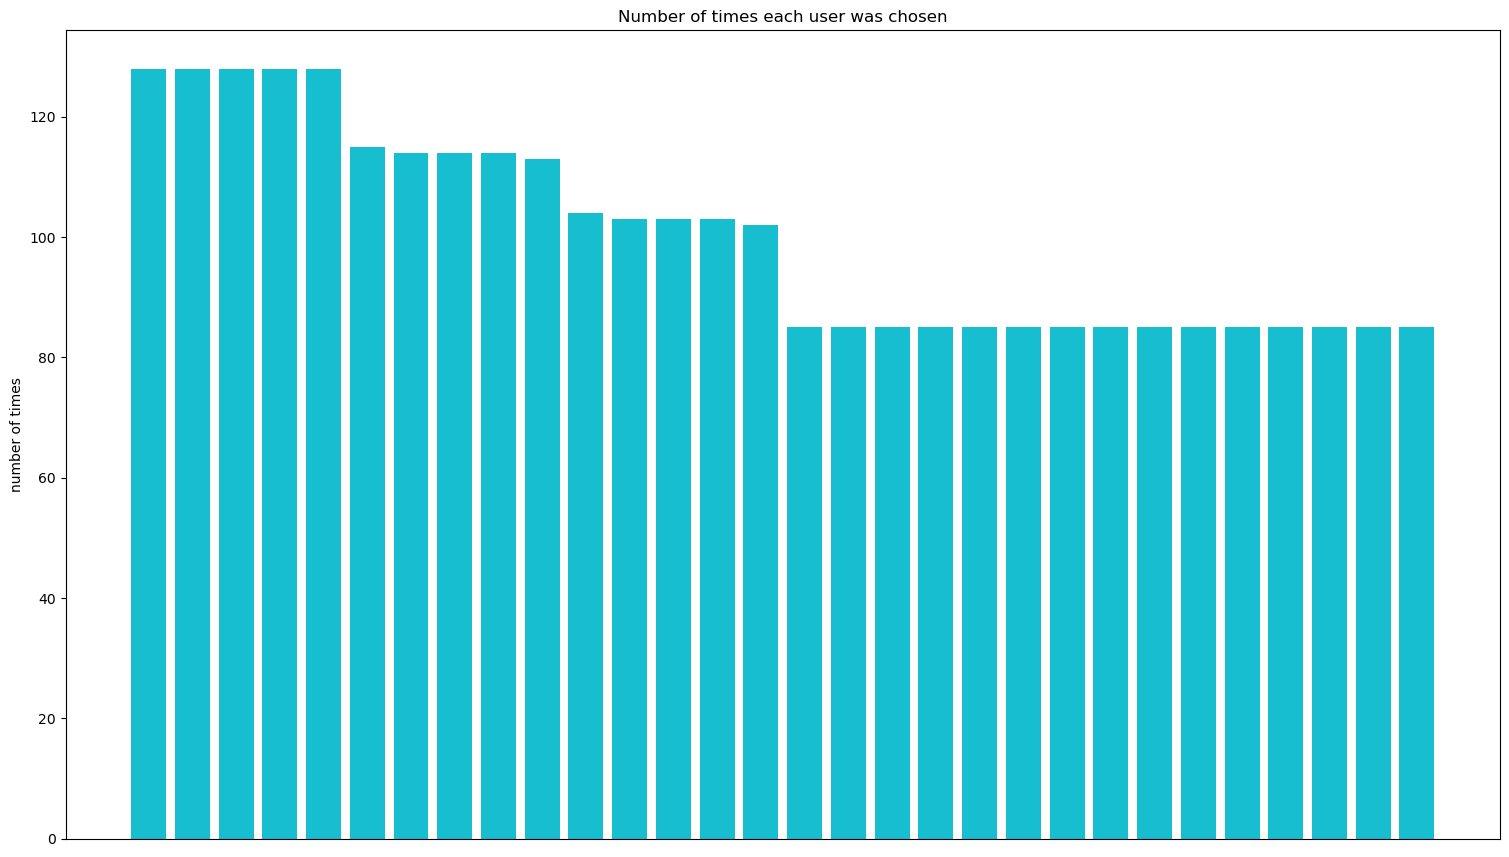

In [10]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []
privacy_violations_list = []
max_privacy_violation = 0


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        textio.cprint(f"iteration: {global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, global_epoch, textio, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    num_slow_users = 0
    num_fast_users = 0
    for usr_idx in sorted(rounds_choise):
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if local_models[usr_idx].privacy_violation > max_privacy_violation:
            max_privacy_violation = local_models[usr_idx].privacy_violation
        if args.choosing_users_verbose:
            textio.cprint(f"user {usr_idx}, emp_avg: {local_models[usr_idx].emp_avg}, h: {local_models[usr_idx].ucb_generalization}, ucb: {local_models[usr_idx].ucb}, num_of_obs(calculated after picking at this round): {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, g: {local_models[usr_idx].g}, curr_delay = {local_models[usr_idx].last_access_time}")
        if usr_idx < args.num_users//2:
            num_fast_users += 1
        else:
            num_slow_users += 1
    if args.choosing_users_verbose:
        textio.cprint(f"num of fast users chosen: {num_fast_users}, num of slow users chosen: {num_slow_users}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        textio.cprint(f"max_delay = {max_delay:.2f} seconds")

    privacy_violations_list.append(max_privacy_violation)
    
    
    
    """Part 2: Training"""
    learning_utils.distribute_model(local_models, global_model)
    users_avg_loss_over_local_epochs = []

    for user_idx in rounds_choise:
        user_loss = []
        for local_epoch in range(args.local_epochs):
            user = local_models[user_idx]
            train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
            if args.lr_scheduler:
                user.scheduler.step(train_loss)
            user_loss.append(train_loss)
        users_avg_loss_over_local_epochs.append(mean(user_loss))
    
    avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
    train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


    avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise, textio
                                                     ,args, snr_verbose = args.snr_verbose)
    # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
    # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
    # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

    val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
    val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

    # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
    #                                     "val_loss": val_loss}, time.time()-start_time)
    # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


    time_counter += max_delay
    textio.cprint((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
    global_epochs_time_list.append(time_counter)
    gc.collect()


    if val_acc > best_val_acc and args.save_best_model:
        best_val_acc = val_acc
        torch.save({"model's state dict":global_model.state_dict(),
                    "train_loss_list": train_loss_list,
                    "val_acc_list": val_acc_list,
                    "val_losses_list": val_losses_list,
                    "global_epochs_time_list": global_epochs_time_list,
                    "num_of_users": args.num_users,
                    "num_of_users_per_round": args.num_users_per_round,
                    "privacy_violations_list": privacy_violations_list}
                    , path_best_model)
    
    
    torch.save({"model's state dict":global_model.state_dict(),
                "train_loss_list": train_loss_list,
                "val_acc_list": val_acc_list,
                "val_losses_list": val_losses_list,
                "global_epochs_time_list": global_epochs_time_list,
                "num_of_obs_arr": num_of_obs_arr.reshape(-1),
                "global_epoch": global_epoch,
                "num_of_users": args.num_users,
                "num_of_users_per_round": args.num_users_per_round,
                "privacy_violations_list": privacy_violations_list}
                , last_model_path)
    
    users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
    plt.bar(users_idxs, num_of_obs_arr.reshape(-1))
    plt.title("Number of times each user was chosen")
    plt.ylabel("number of times")
    #hide x labels 
    plt.xticks([])
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    #boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
    plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

    if time_counter > args.max_seconds:
        break


